In [1]:
import random 
import datetime
import cryptocompare as cc
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans
pd.set_option('display.max_colwidth', None)
random.seed(a=322, version=2)

C:\Users\oleg\AppData\Local\Temp\ipykernel_15100\1226490409.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Load and prepare data

In [2]:
crypto_list = cc.get_coin_list(format=True)
cripto_list_sample = random.sample(crypto_list, 1000)

if 'BTC' not in cripto_list_sample: 
    cripto_list_sample.insert(0, 'BTC')
else:
    idx = cripto_list_sample.index('BTC')
    _ = cripto_list_sample[0]
    cripto_list_sample[0] = 'BTC'
    cripto_list_sample[idx] = _

In [3]:
# не все тикеты имеют конвертацию в USD, для парсинга > 50 тикеров нужна платная подписка
def get_full_ticker_df(case: str, cripto_list_sample: list, N: int=50):
    assert case in ['day','hour','min'], "case should be in [day, hour, min]"
    iterator = 0
    df_full = []
    for ticker in tqdm(cripto_list_sample):
        if case == 'day': data = cc.get_historical_price_day(ticker, currency='USD', limit=30)
        elif case == 'hour': data = cc.get_historical_price_hour(ticker, currency='USD', limit=3*24)
        elif case == 'min': data = cc.get_historical_price_minute(ticker, currency='USD', limit=60)
        if data:
            iterator += 1
            df = pd.DataFrame(data=data)[['time','close']].rename({'close': ticker}, axis=1)
            df_full.append(df)
            if iterator == N: 
                break
    df_full = pd.concat(df_full, axis=1, ignore_index=False)
    df_full = df_full.loc[:,~df_full.columns.duplicated()].copy()
    df_full['time'] = pd.to_datetime(df_full['time'], unit='s')
    df_full = df_full.set_index('time')
    return df_full

In [4]:
full_ticker_df = get_full_ticker_df('day', cripto_list_sample, 50)

  0%|          | 0/1001 [00:00<?, ?it/s]

[ERROR] CCCAGG market does not exist for this coin pair (CYS-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CFXQ-USD)
[ERROR] CCCAGG market does not exist for this coin pair (OWN-USD)
[ERROR] CCCAGG market does not exist for this coin pair (FOCV-USD)
[ERROR] CCCAGG market does not exist for this coin pair (VYBE-USD)
[ERROR] CCCAGG market does not exist for this coin pair (GFCE-USD)
[ERROR] CCCAGG market does not exist for this coin pair (NEXBT-USD)
[ERROR] CCCAGG market does not exist for this coin pair (NXD-USD)
[ERROR] CCCAGG market does not exist for this coin pair (BPRIVA-USD)
[ERROR] CCCAGG market does not exist for this coin pair (GOFX-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CALC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (POSTC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (XDAG-USD)
[ERROR] CCCAGG market does not exist for this coin pair (DINU-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CBOT

In [5]:
full_ticker_df.head(3)

BTC      BLOC          ETBS      LUA     LVX     DDX  \
time                                                                    
2023-06-23  30700.29  0.000307  9.200000e-07  0.01294  0.1569  0.3066   
2023-06-24  30548.03  0.000305  9.200000e-07  0.01294  0.1569  0.3023   
2023-06-25  30473.33  0.000305  9.100000e-07  0.01294  0.1569  0.3049   

                GMAT      BTBL    RPL      MOT  ...      GC       PHC  \
time                                            ...                     
2023-06-23  0.000076  0.000155  40.70  0.06294  ...  0.0045  0.000215   
2023-06-24  0.000075  0.000916  38.43  0.06262  ...  0.0045  0.000214   
2023-06-25  0.000076  0.000110  38.63  0.06247  ...  0.0045  0.000213   

                GLC     TDFB   NFTX     MEME      NOR           BBS  LGX  \
time                                                                       
2023-06-23  0.01367  0.01800  12.43  0.03500  0.05373  3.100000e-07    0   
2023-06-24  0.01100  0.01457  12.41  0.03299  0.09898  3.100000e-07    0   
2023-06-25  0.01778  0.01457  12.71  0.03322  0.04114  3.000000e-07    0   

                CAID  
time                  
2023-06-23  0.000041  
2023-06-24  0.000045  
2023-06-25  0.000045  

[3 rows x 50 columns]

In [6]:
full_ticker_df.T.head(3)

time    2023-06-23    2023-06-24    2023-06-25    2023-06-26    2023-06-27  \
BTC   3.070029e+04  3.054803e+04  3.047333e+04  3.027461e+04  3.069821e+04   
BLOC  3.070000e-04  3.055000e-04  3.047000e-04  3.027000e-04  3.070000e-04   
ETBS  9.200000e-07  9.200000e-07  9.100000e-07  9.100000e-07  9.200000e-07   

time    2023-06-28    2023-06-29    2023-06-30    2023-07-01    2023-07-02  \
BTC   3.008024e+04  3.044653e+04  3.047100e+04  3.059071e+04  3.061842e+04   
BLOC  3.008000e-04  3.045000e-04  3.047000e-04  3.059000e-04  3.062000e-04   
ETBS  9.000000e-07  9.100000e-07  9.100000e-07  9.200000e-07  9.200000e-07   

time  ...    2023-07-14    2023-07-15    2023-07-16    2023-07-17  \
BTC   ...  3.032963e+04  3.029863e+04  3.024817e+04  3.014760e+04   
BLOC  ...  3.033000e-04  3.030000e-04  3.025000e-04  3.015000e-04   
ETBS  ...  9.100000e-07  9.100000e-07  9.100000e-07  9.000000e-07   

time    2023-07-18    2023-07-19    2023-07-20    2023-07-21    2023-07-22  \
BTC   2.986332e+04  2.991831e+04  2.980967e+04  2.991093e+04  2.979037e+04   
BLOC  2.986000e-04  2.992000e-04  2.981000e-04  2.991000e-04  2.979000e-04   
ETBS  9.000000e-07  9.000000e-07  8.900000e-07  9.000000e-07  8.900000e-07   

time    2023-07-23  
BTC   29900.370000  
BLOC      0.000299  
ETBS      0.897000  

[3 rows x 31 columns]

In [7]:
def scale_and_plot_ticker_df(full_ticker_df):
    scaler = StandardScaler()
    tickers_scaled = scaler.fit_transform(full_ticker_df).T
    pd.DataFrame(data=tickers_scaled.T, index=full_ticker_df.index, columns=full_ticker_df.columns).plot()
    return(tickers_scaled)

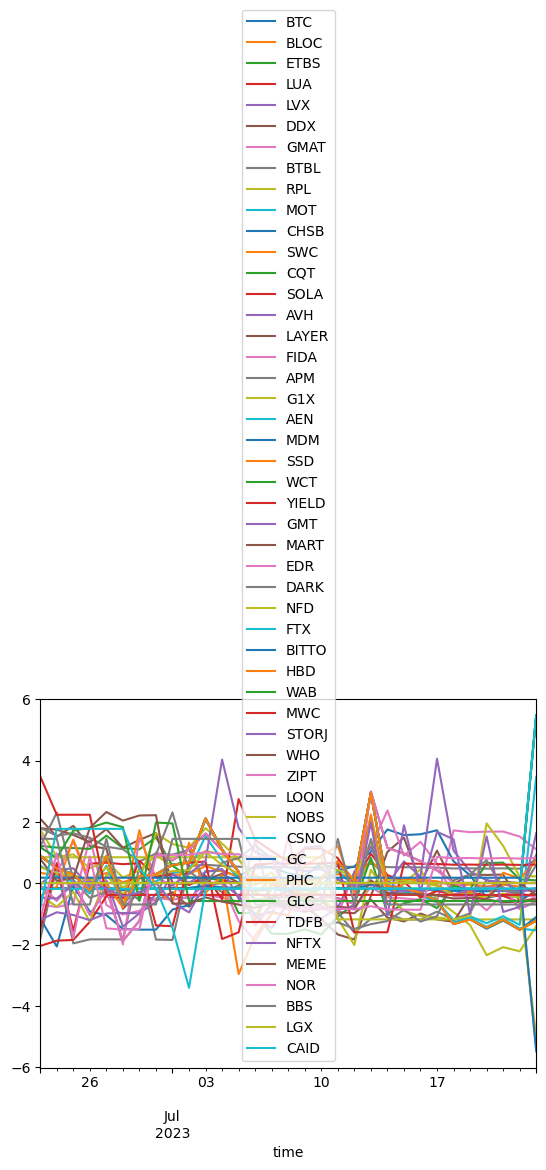

In [8]:
tickers_scaled = scale_and_plot_ticker_df(full_ticker_df)

# ML part
## Classical algo
### За последние 30 дней с дневной частотой

In [9]:
def plot_clustering_metrics(tickers_scaled: pd.Series, metric: str="euclidean"):    
    distortions = [] # Сумма кв расстояний от объектов до центра кластера, взвешенная по весам (при их наличии)
    silhouette = []
    K = range(2, 10)
    for k in tqdm(K):
        kmeanModel = TimeSeriesKMeans(n_clusters=k, metric=metric, n_jobs=6, max_iter=10, n_init=5)
        kmeanModel.fit(tickers_scaled)
        distortions.append(kmeanModel.inertia_)
        silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric=metric))
        # silhouette_score считает насколько чисты кластеры - (от -1 до 1, больше, лучше)
    fig, ax1 = plt.subplots(figsize=(6, 3))
    ax2 = ax1.twinx()
    ax1.plot(K, distortions, linestyle='--', marker='o', markersize=10, alpha=0.5, c='b')
    ax2.plot(K, silhouette, linestyle='--', marker='o', markersize=10, alpha=0.5, c='r')
    ax1.set_xlabel('№ of clusters')
    ax1.set_ylabel('Distortion', color='b')
    ax2.set_ylabel('Silhouette', color='r')
    plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

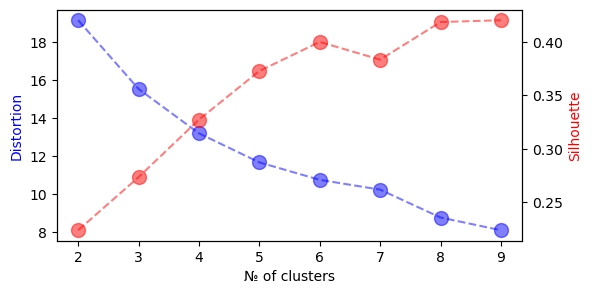

In [10]:
plot_clustering_metrics(tickers_scaled, "euclidean")

In [11]:
def train_and_plot_algo(n_clusters, tickers_scaled, full_ticker_df, metric: str="euclidean"):
    ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, n_jobs=6, max_iter=10)
    ts_kmeans.fit(tickers_scaled)
    
    for cluster_number in range(n_clusters): # Построим усредненные ряды внутри каждого кластера
        plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
    plt.title("Cluster centroids") 
    plt.legend()
    plt.show()
    
    df = full_ticker_df.copy()
    df = df.T.reset_index().rename({'index': 'ticker'}, axis=1)
    df.columns.name = ''
    df['cluster'] = ts_kmeans.predict(tickers_scaled)
    return ts_kmeans, df

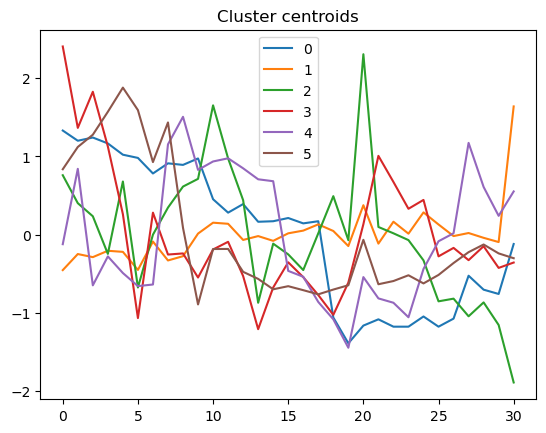

C:\Users\oleg\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 50 1-dimensional timeseries
  warnings.warn(


In [12]:
n_clusters = 6
ts_kmeans, df = train_and_plot_algo(n_clusters, tickers_scaled, full_ticker_df, "euclidean")

In [13]:
# число тикетов в кластерах
def show_tikers_in_claster(data):
    results = pd.DataFrame(data.groupby(['cluster'])['ticker'].agg(lambda x: ' '.join(x)))
    results['№ of tickers in claster'] = data.groupby(['cluster'])['ticker'].count()
    return results

In [14]:
results_of_clustering = {}
results_of_clustering['day'] = show_tikers_in_claster(df)
results_of_clustering['day']

ticker  \
cluster                                                                                                      
0                                                                                                  APM G1X   
1        ETBS LUA LVX GMAT BTBL MOT CHSB AEN YIELD GMT MART EDR DARK BITTO HBD WAB MWC STORJ CSNO NFTX LGX   
2                                       BTC BLOC RPL SWC SOLA AVH MDM SSD WCT FTX WHO ZIPT NOBS GC PHC BBS   
3                                                                                            DDX FIDA TDFB   
4                                                                                             NFD LOON NOR   
5                                                                                  CQT LAYER GLC MEME CAID   

         № of tickers in claster  
cluster                           
0                              2  
1                             21  
2                             16  
3                              3  
4                              3  
5                              5

In [15]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)
    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row[1:-1])
        ax[index].set_title(f"{row['ticker']}\n{row['cluster']}")
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_cluster_tickers_for_clusters(df, n_clusters):
    for cluster in range(n_clusters):
        print("=================================================================================")
        print(f"                          Cluster number: {cluster}")
        print("=================================================================================")
        plot_cluster_tickers(df[df['cluster']==cluster])

                          Cluster number: 0


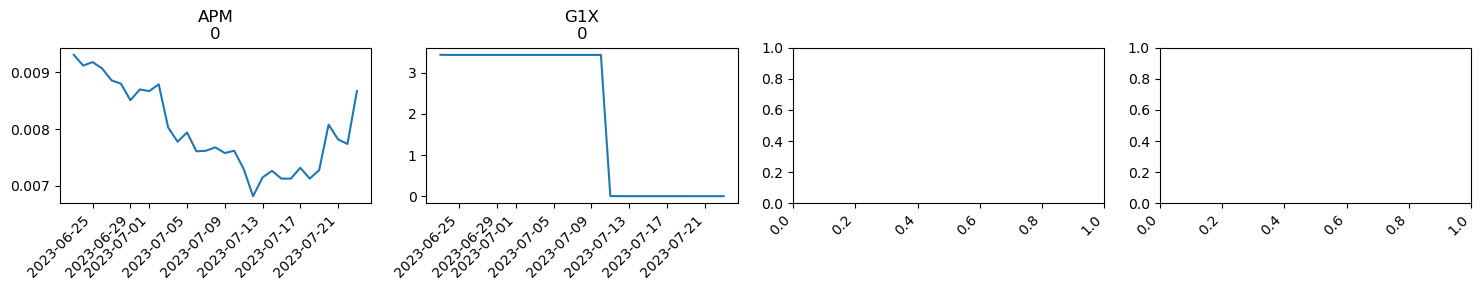

                          Cluster number: 1


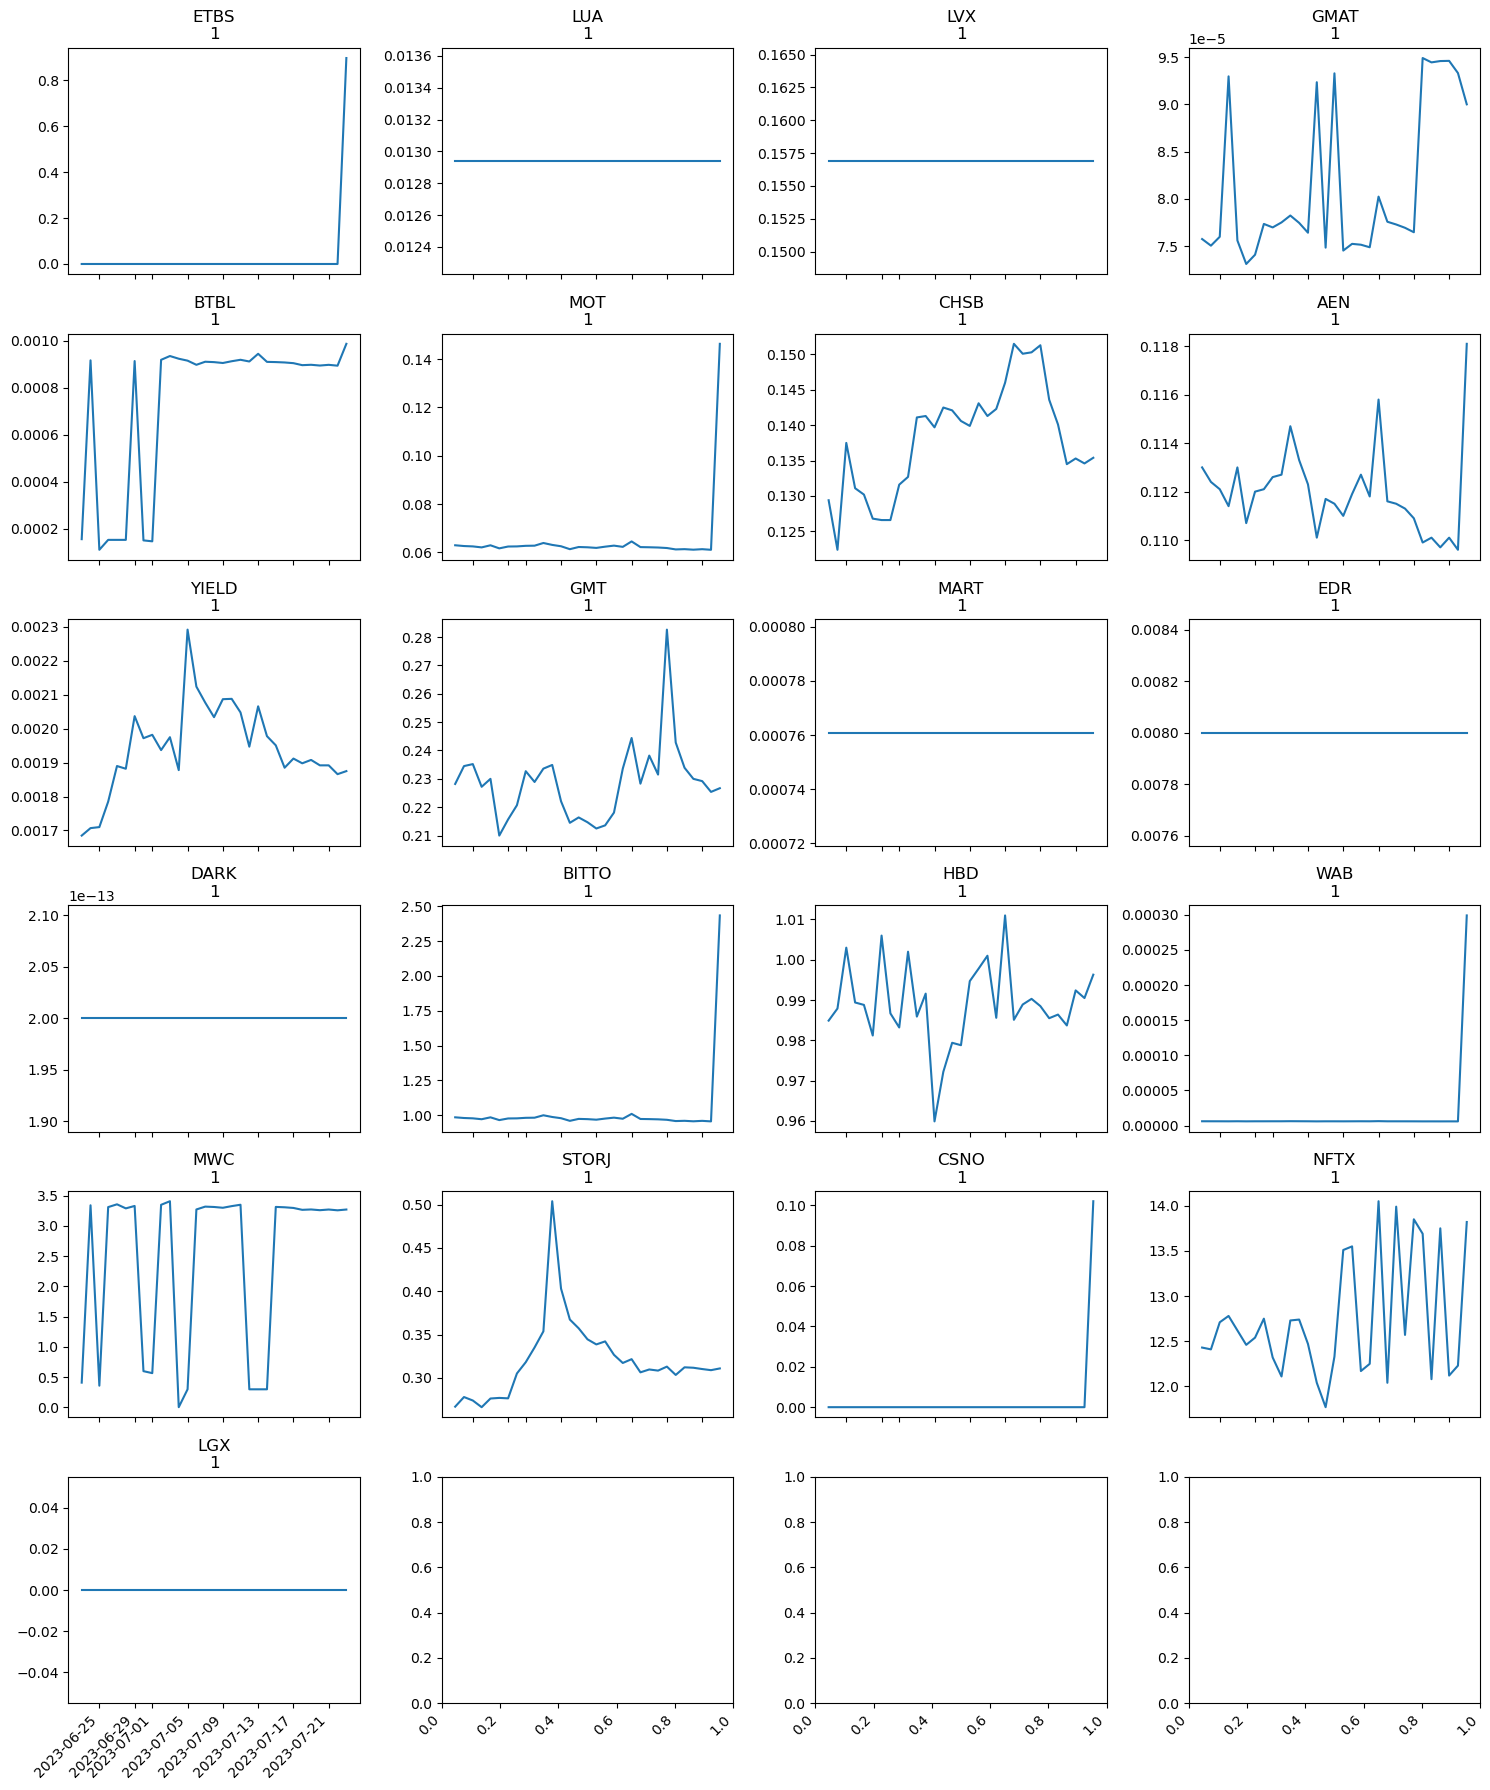

                          Cluster number: 2


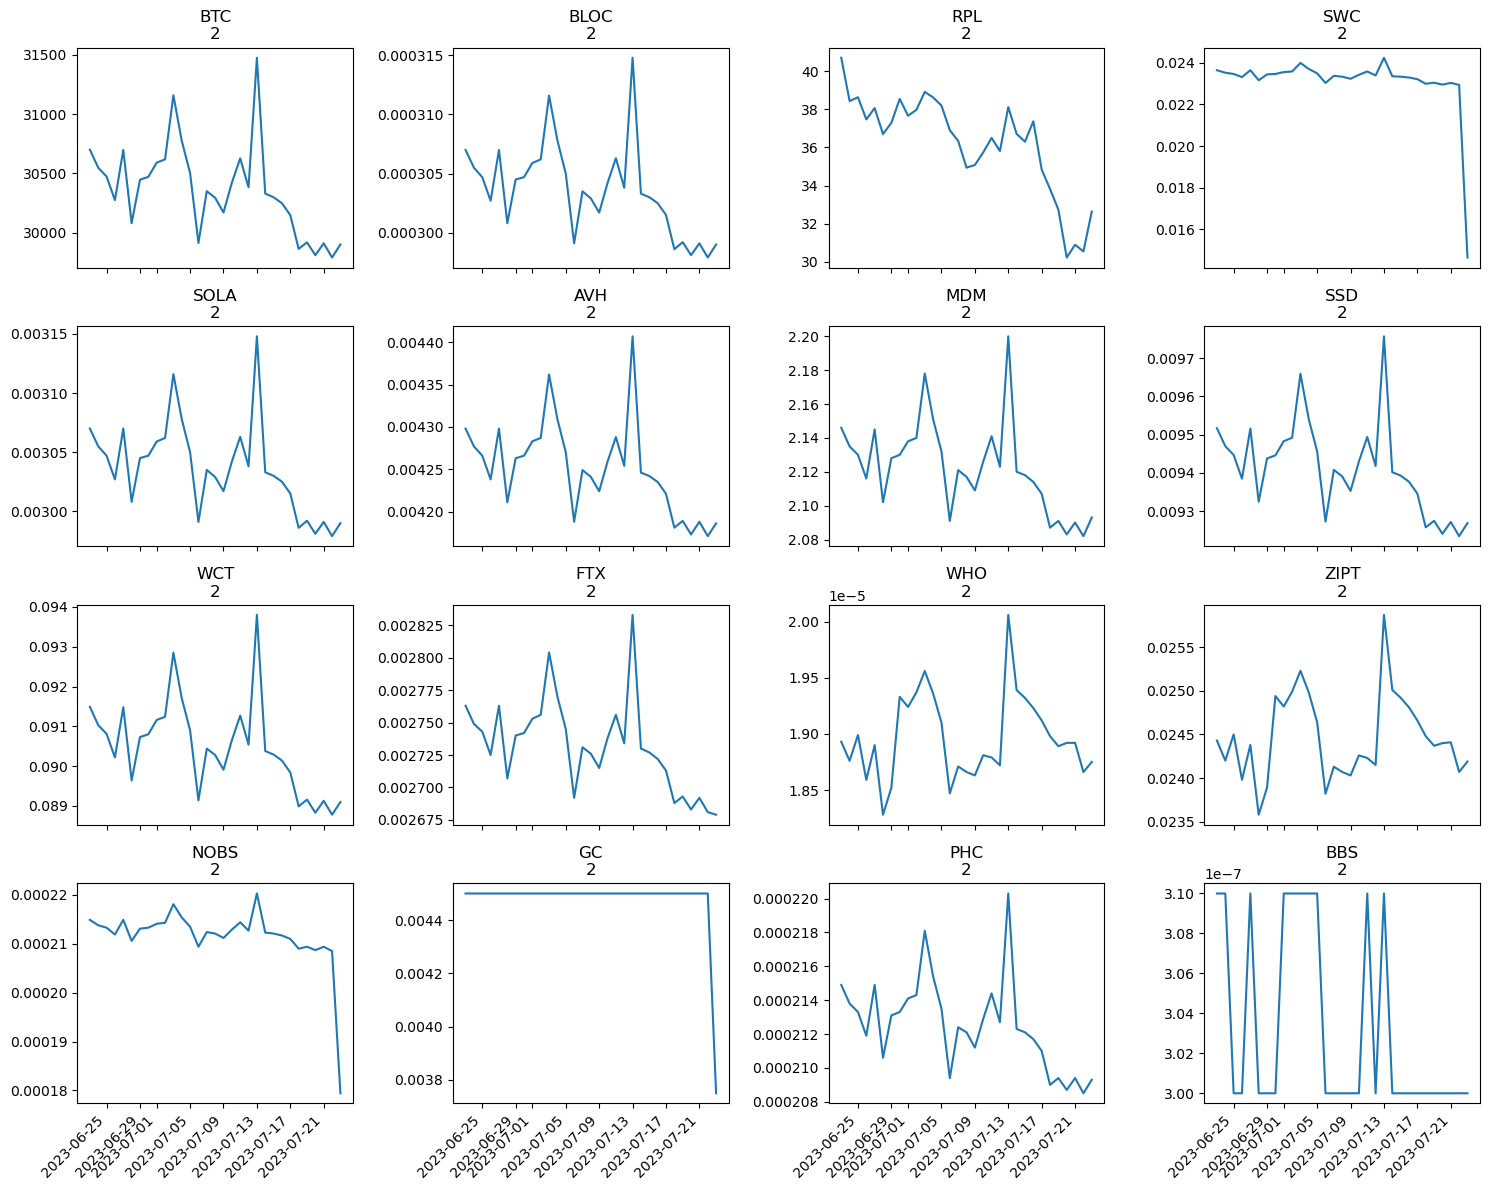

                          Cluster number: 3


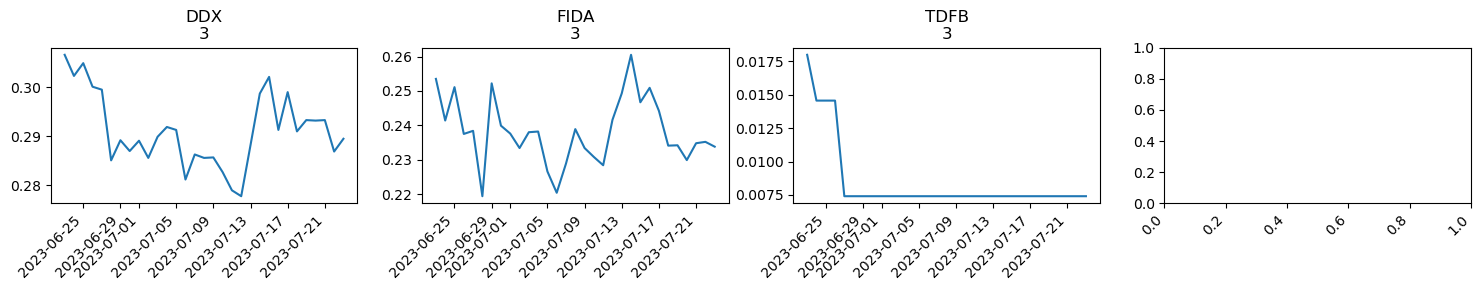

                          Cluster number: 4


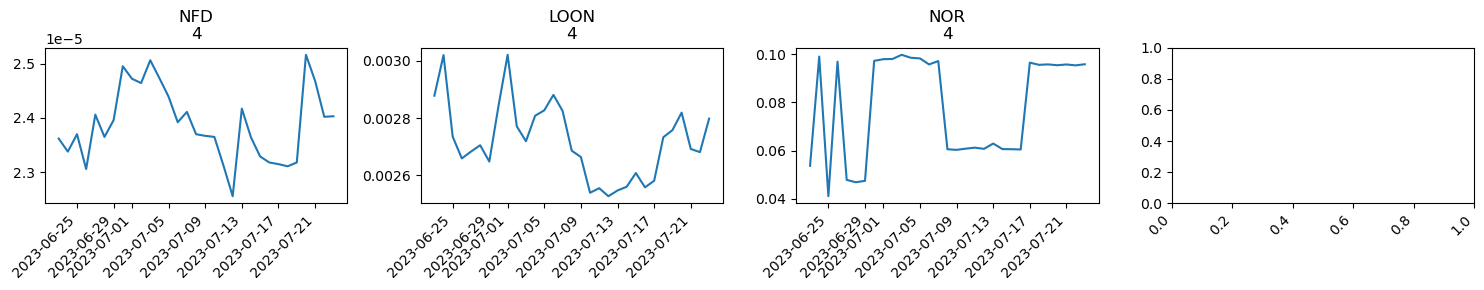

                          Cluster number: 5


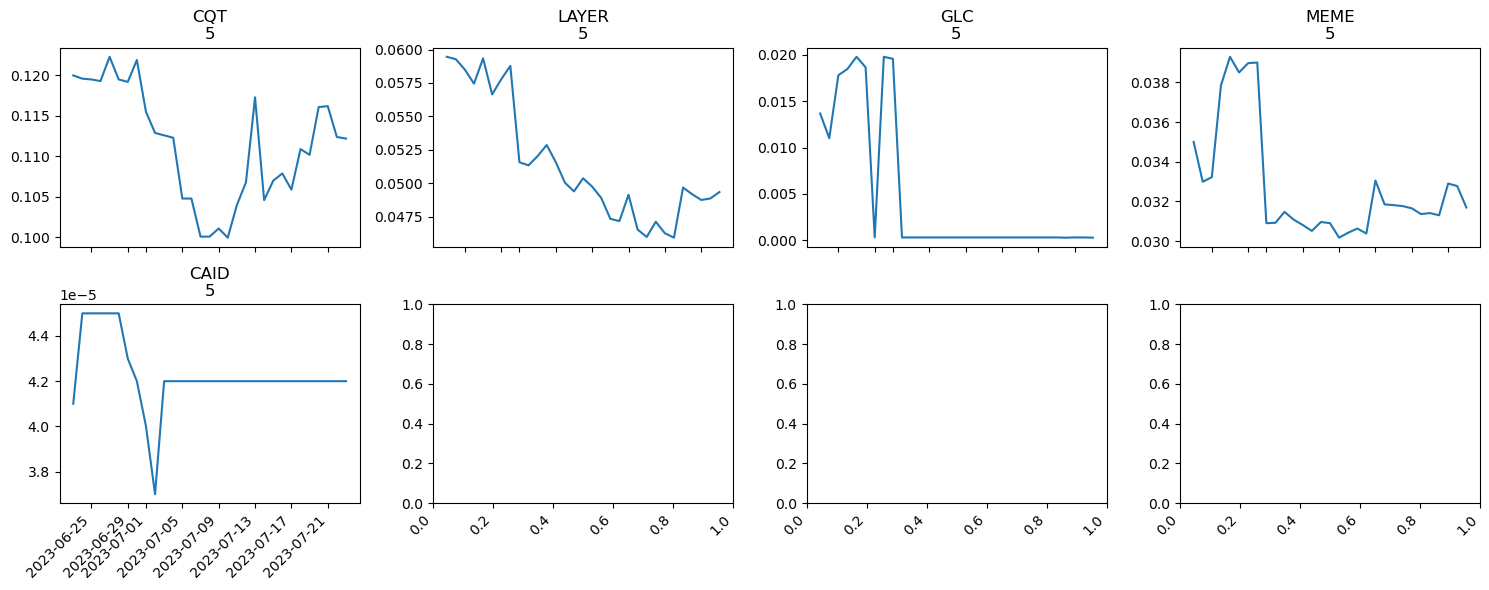

In [17]:
plot_cluster_tickers_for_clusters(df, n_clusters)

### За последние 3 дня с часовой частотой 

In [18]:
full_ticker_df = get_full_ticker_df('hour', cripto_list_sample, 50)

  0%|          | 0/1001 [00:00<?, ?it/s]

[ERROR] CCCAGG market does not exist for this coin pair (CYS-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CFXQ-USD)
[ERROR] CCCAGG market does not exist for this coin pair (OWN-USD)
[ERROR] CCCAGG market does not exist for this coin pair (FOCV-USD)
[ERROR] CCCAGG market does not exist for this coin pair (VYBE-USD)
[ERROR] CCCAGG market does not exist for this coin pair (GFCE-USD)
[ERROR] CCCAGG market does not exist for this coin pair (NEXBT-USD)
[ERROR] CCCAGG market does not exist for this coin pair (NXD-USD)
[ERROR] CCCAGG market does not exist for this coin pair (BPRIVA-USD)
[ERROR] CCCAGG market does not exist for this coin pair (GOFX-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CALC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (POSTC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (XDAG-USD)
[ERROR] CCCAGG market does not exist for this coin pair (DINU-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CBOT

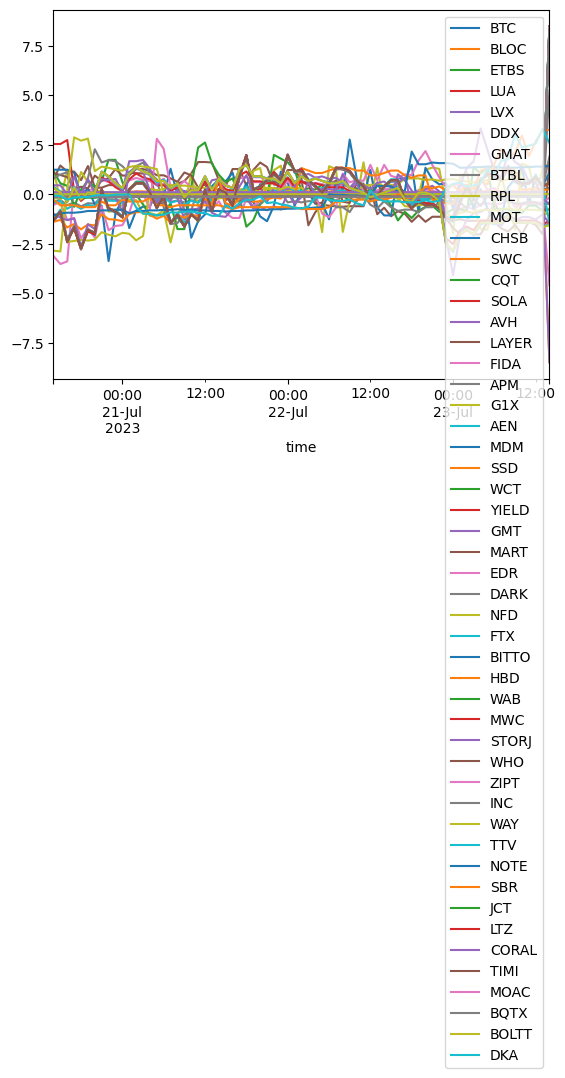

In [19]:
tickers_scaled = scale_and_plot_ticker_df(full_ticker_df)

  0%|          | 0/8 [00:00<?, ?it/s]

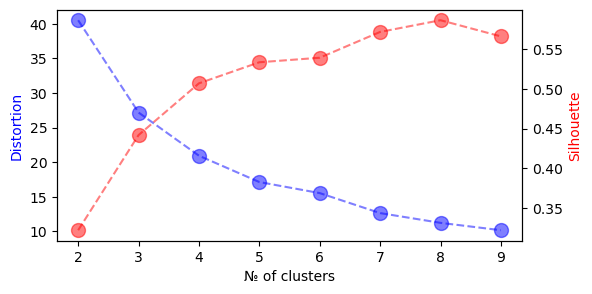

In [20]:
plot_clustering_metrics(tickers_scaled, "euclidean")

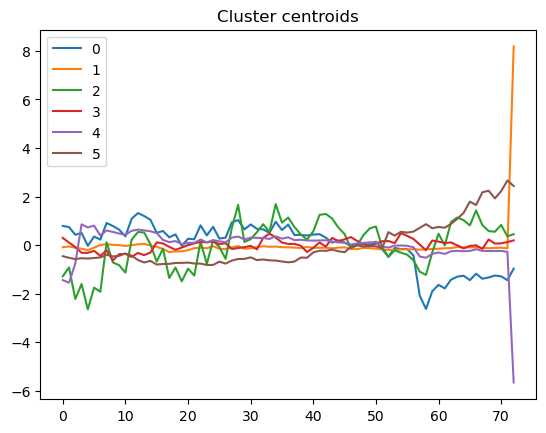

C:\Users\oleg\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 50 1-dimensional timeseries
  warnings.warn(


In [21]:
n_clusters = 6
ts_kmeans, df = train_and_plot_algo(n_clusters, tickers_scaled, full_ticker_df, "euclidean")

In [22]:
results_of_clustering['hour'] = show_tikers_in_claster(df)

                          Cluster number: 0


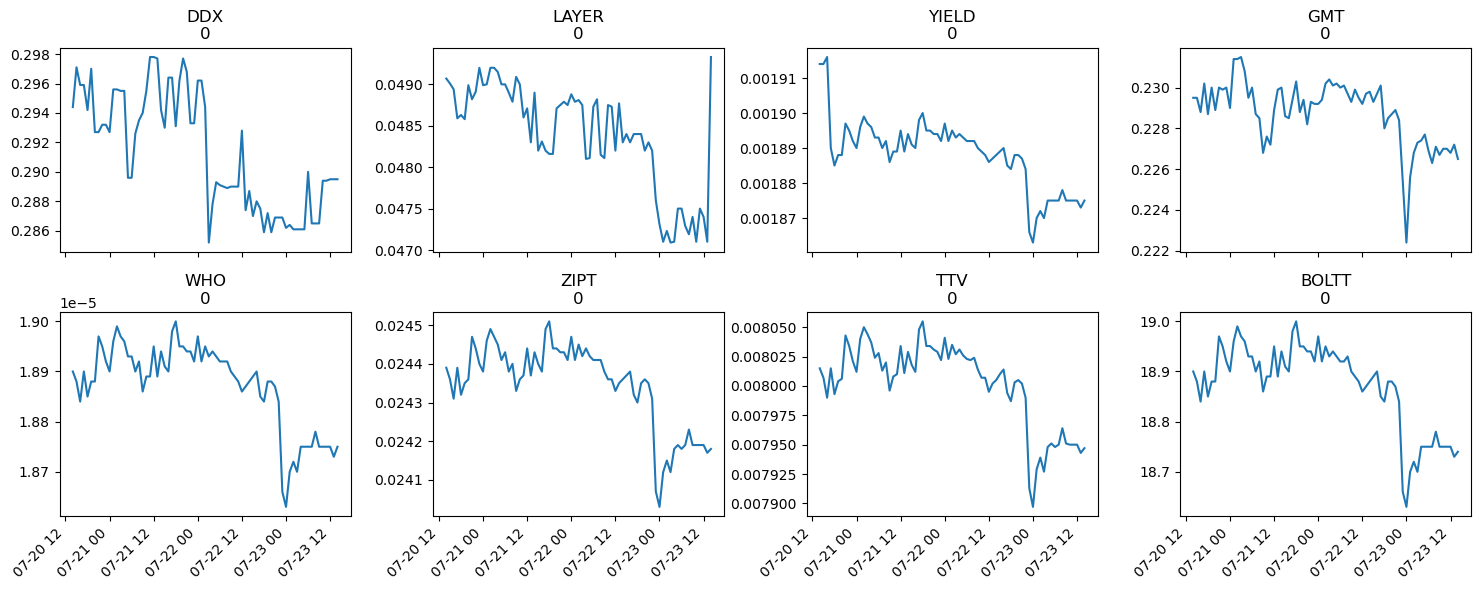

                          Cluster number: 1


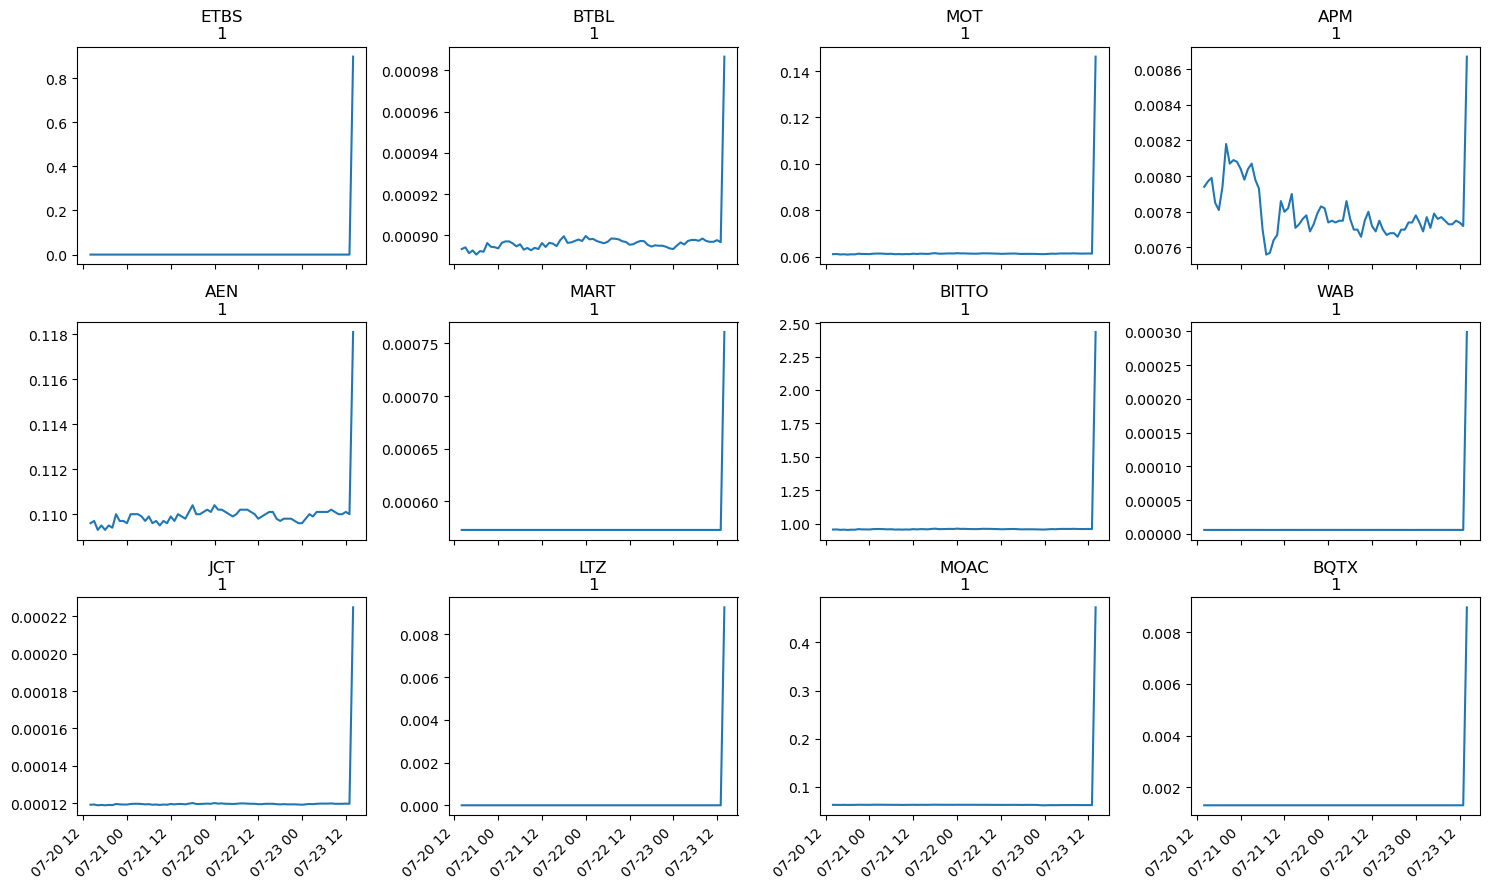

                          Cluster number: 2


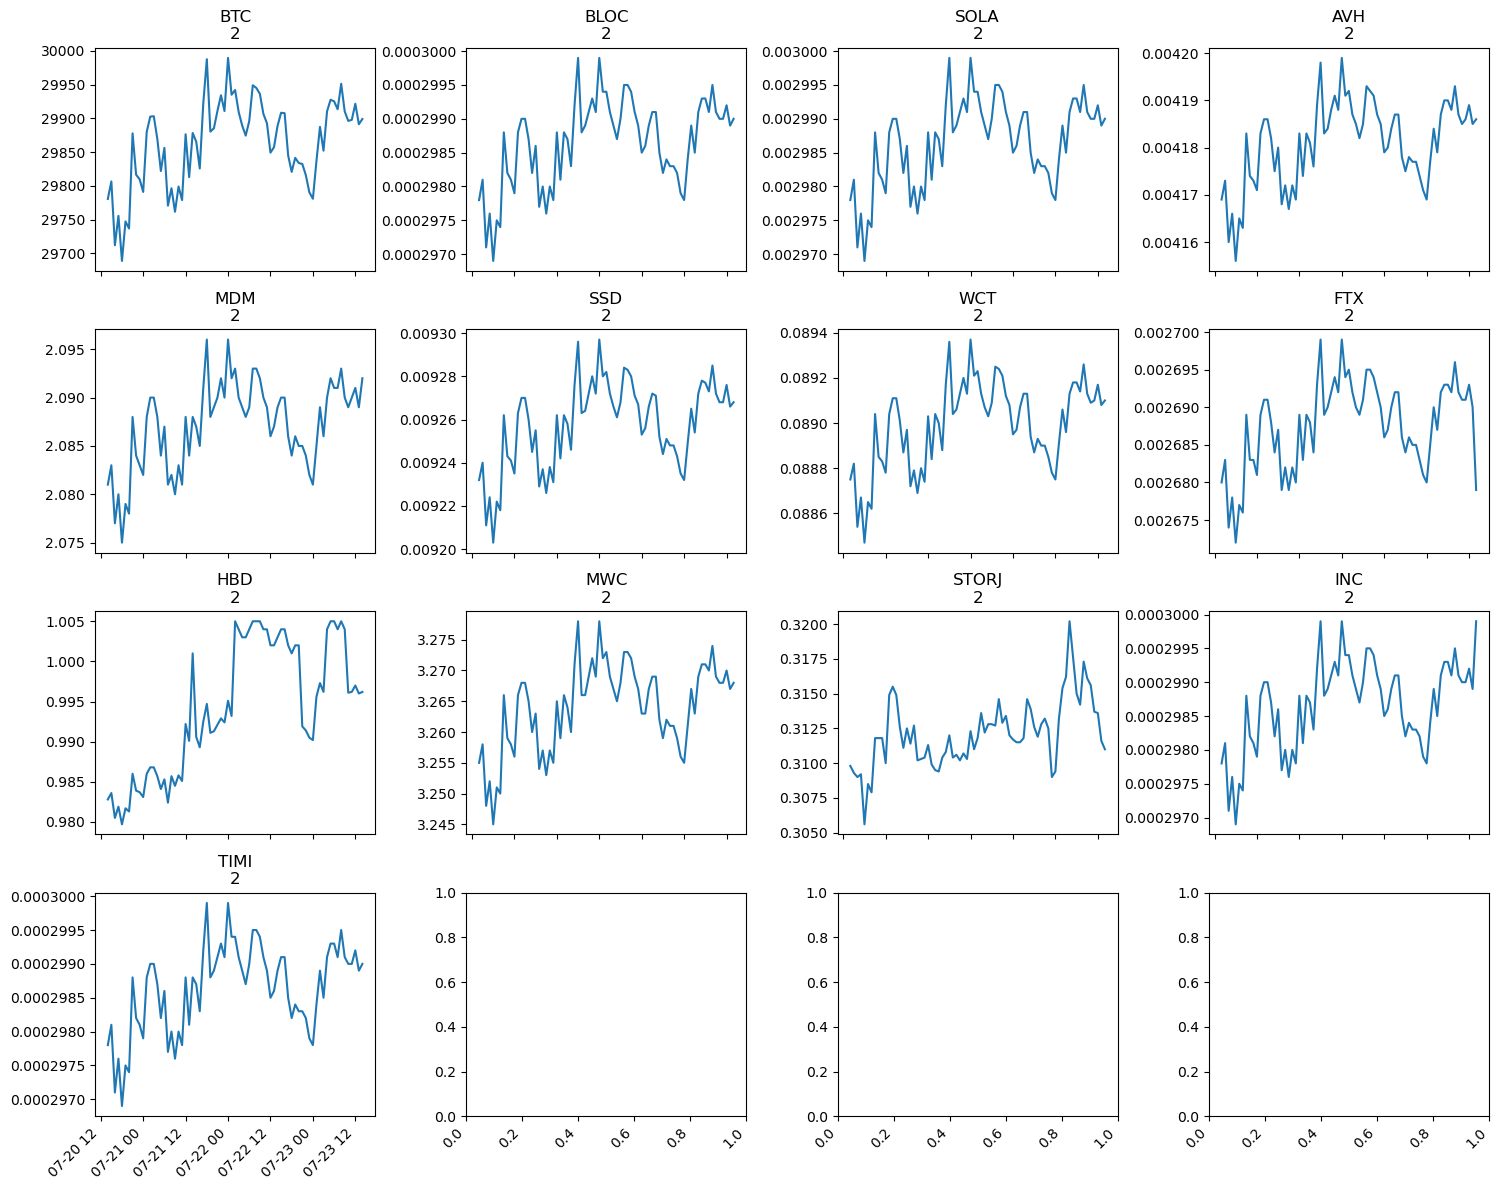

                          Cluster number: 3


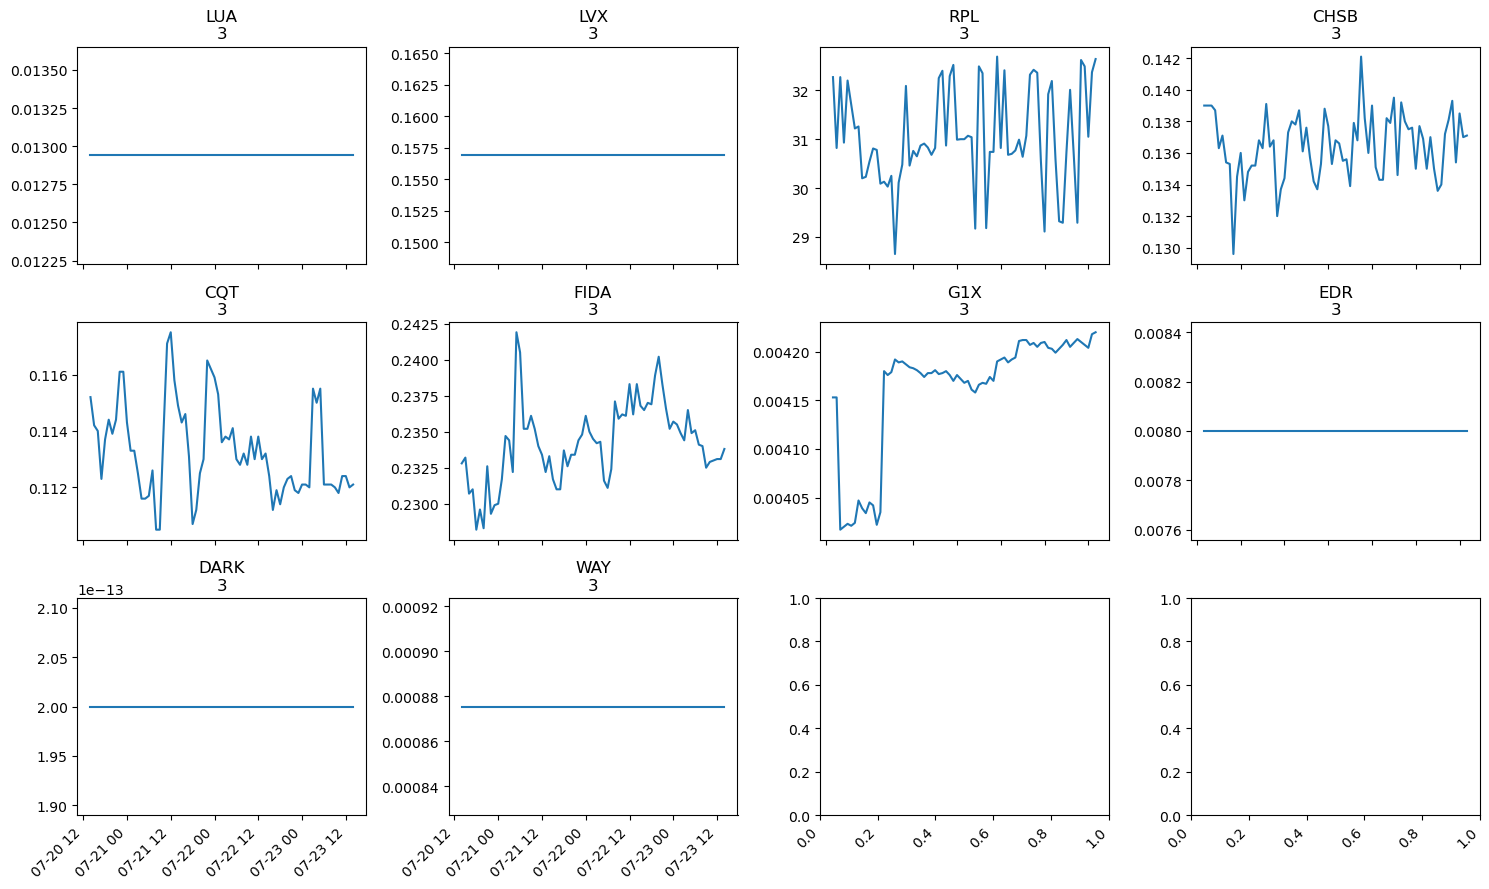

                          Cluster number: 4


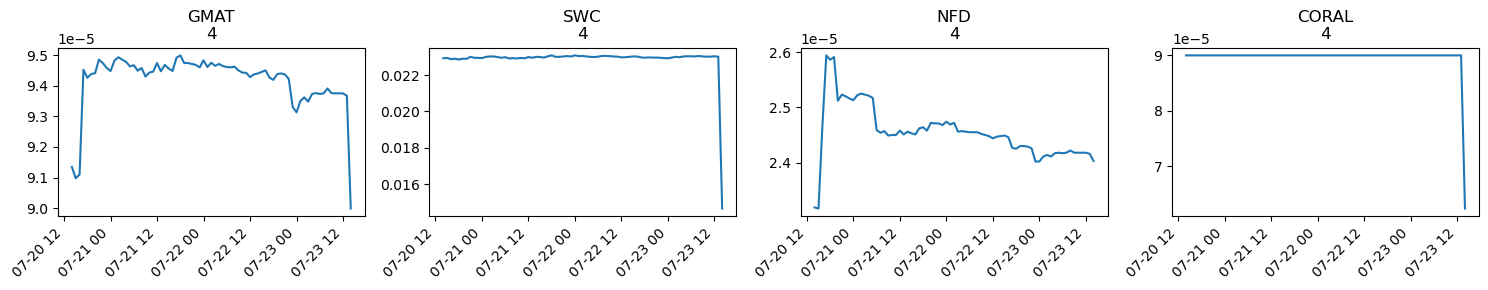

                          Cluster number: 5


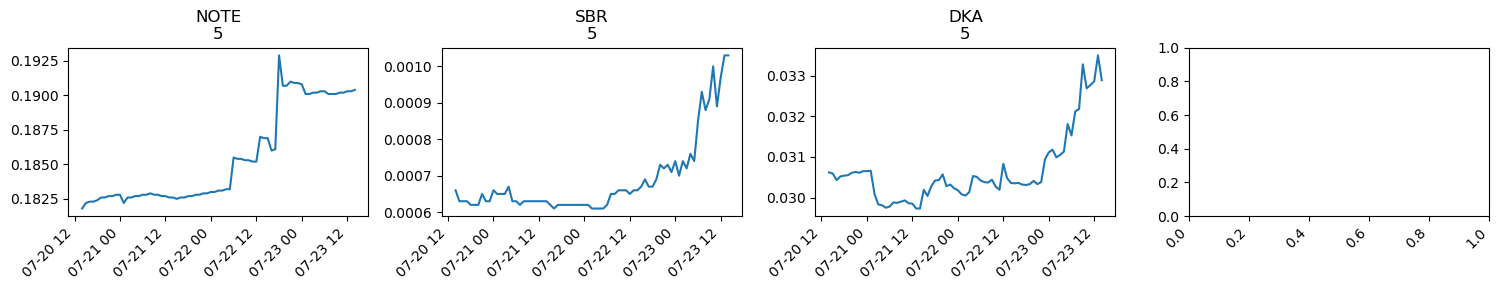

In [23]:
plot_cluster_tickers_for_clusters(df, n_clusters)

### За последний час с минутной частотой

  0%|          | 0/1001 [00:00<?, ?it/s]

[ERROR] CCCAGG market does not exist for this coin pair (CYS-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CFXQ-USD)
[ERROR] CCCAGG market does not exist for this coin pair (OWN-USD)
[ERROR] CCCAGG market does not exist for this coin pair (FOCV-USD)
[ERROR] CCCAGG market does not exist for this coin pair (VYBE-USD)
[ERROR] CCCAGG market does not exist for this coin pair (GFCE-USD)
[ERROR] CCCAGG market does not exist for this coin pair (NEXBT-USD)
[ERROR] CCCAGG market does not exist for this coin pair (NXD-USD)
[ERROR] CCCAGG market does not exist for this coin pair (BPRIVA-USD)
[ERROR] CCCAGG market does not exist for this coin pair (GOFX-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CALC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (POSTC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (XDAG-USD)
[ERROR] CCCAGG market does not exist for this coin pair (DINU-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CBOT

  0%|          | 0/8 [00:00<?, ?it/s]

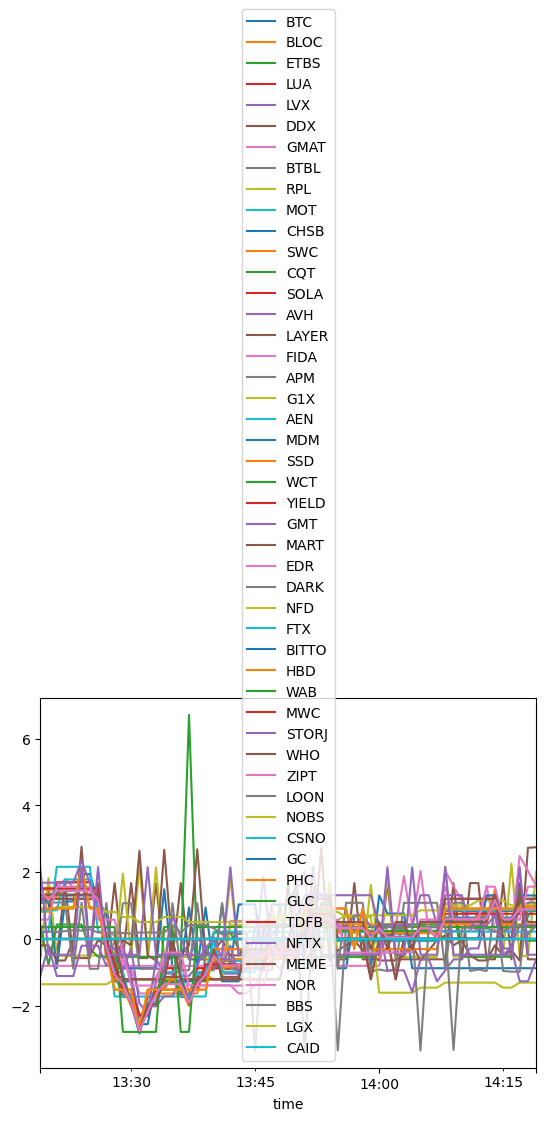

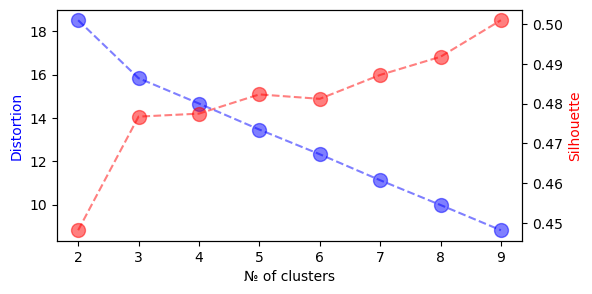

In [24]:
full_ticker_df = get_full_ticker_df('min', cripto_list_sample, 50)
tickers_scaled = scale_and_plot_ticker_df(full_ticker_df)
plot_clustering_metrics(tickers_scaled, "euclidean")

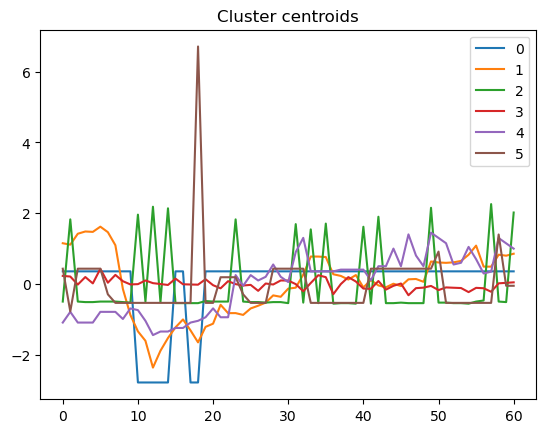

C:\Users\oleg\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 50 1-dimensional timeseries
  warnings.warn(


                          Cluster number: 0


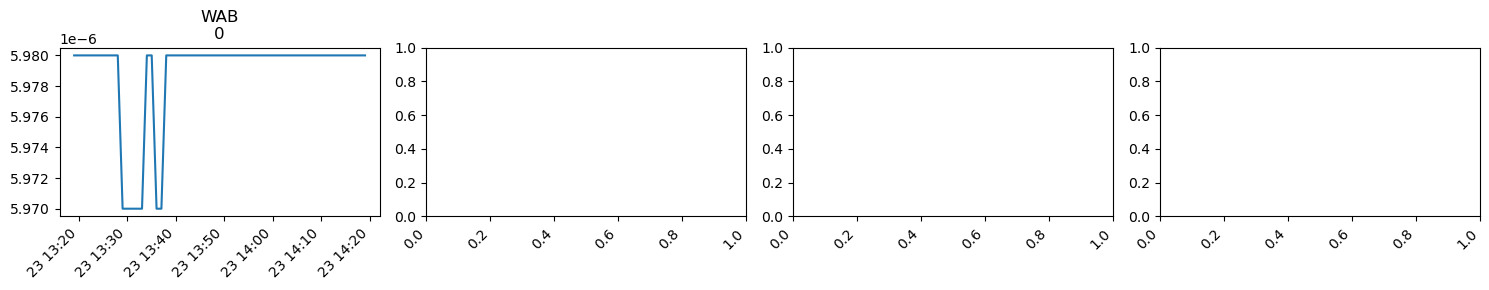

                          Cluster number: 1


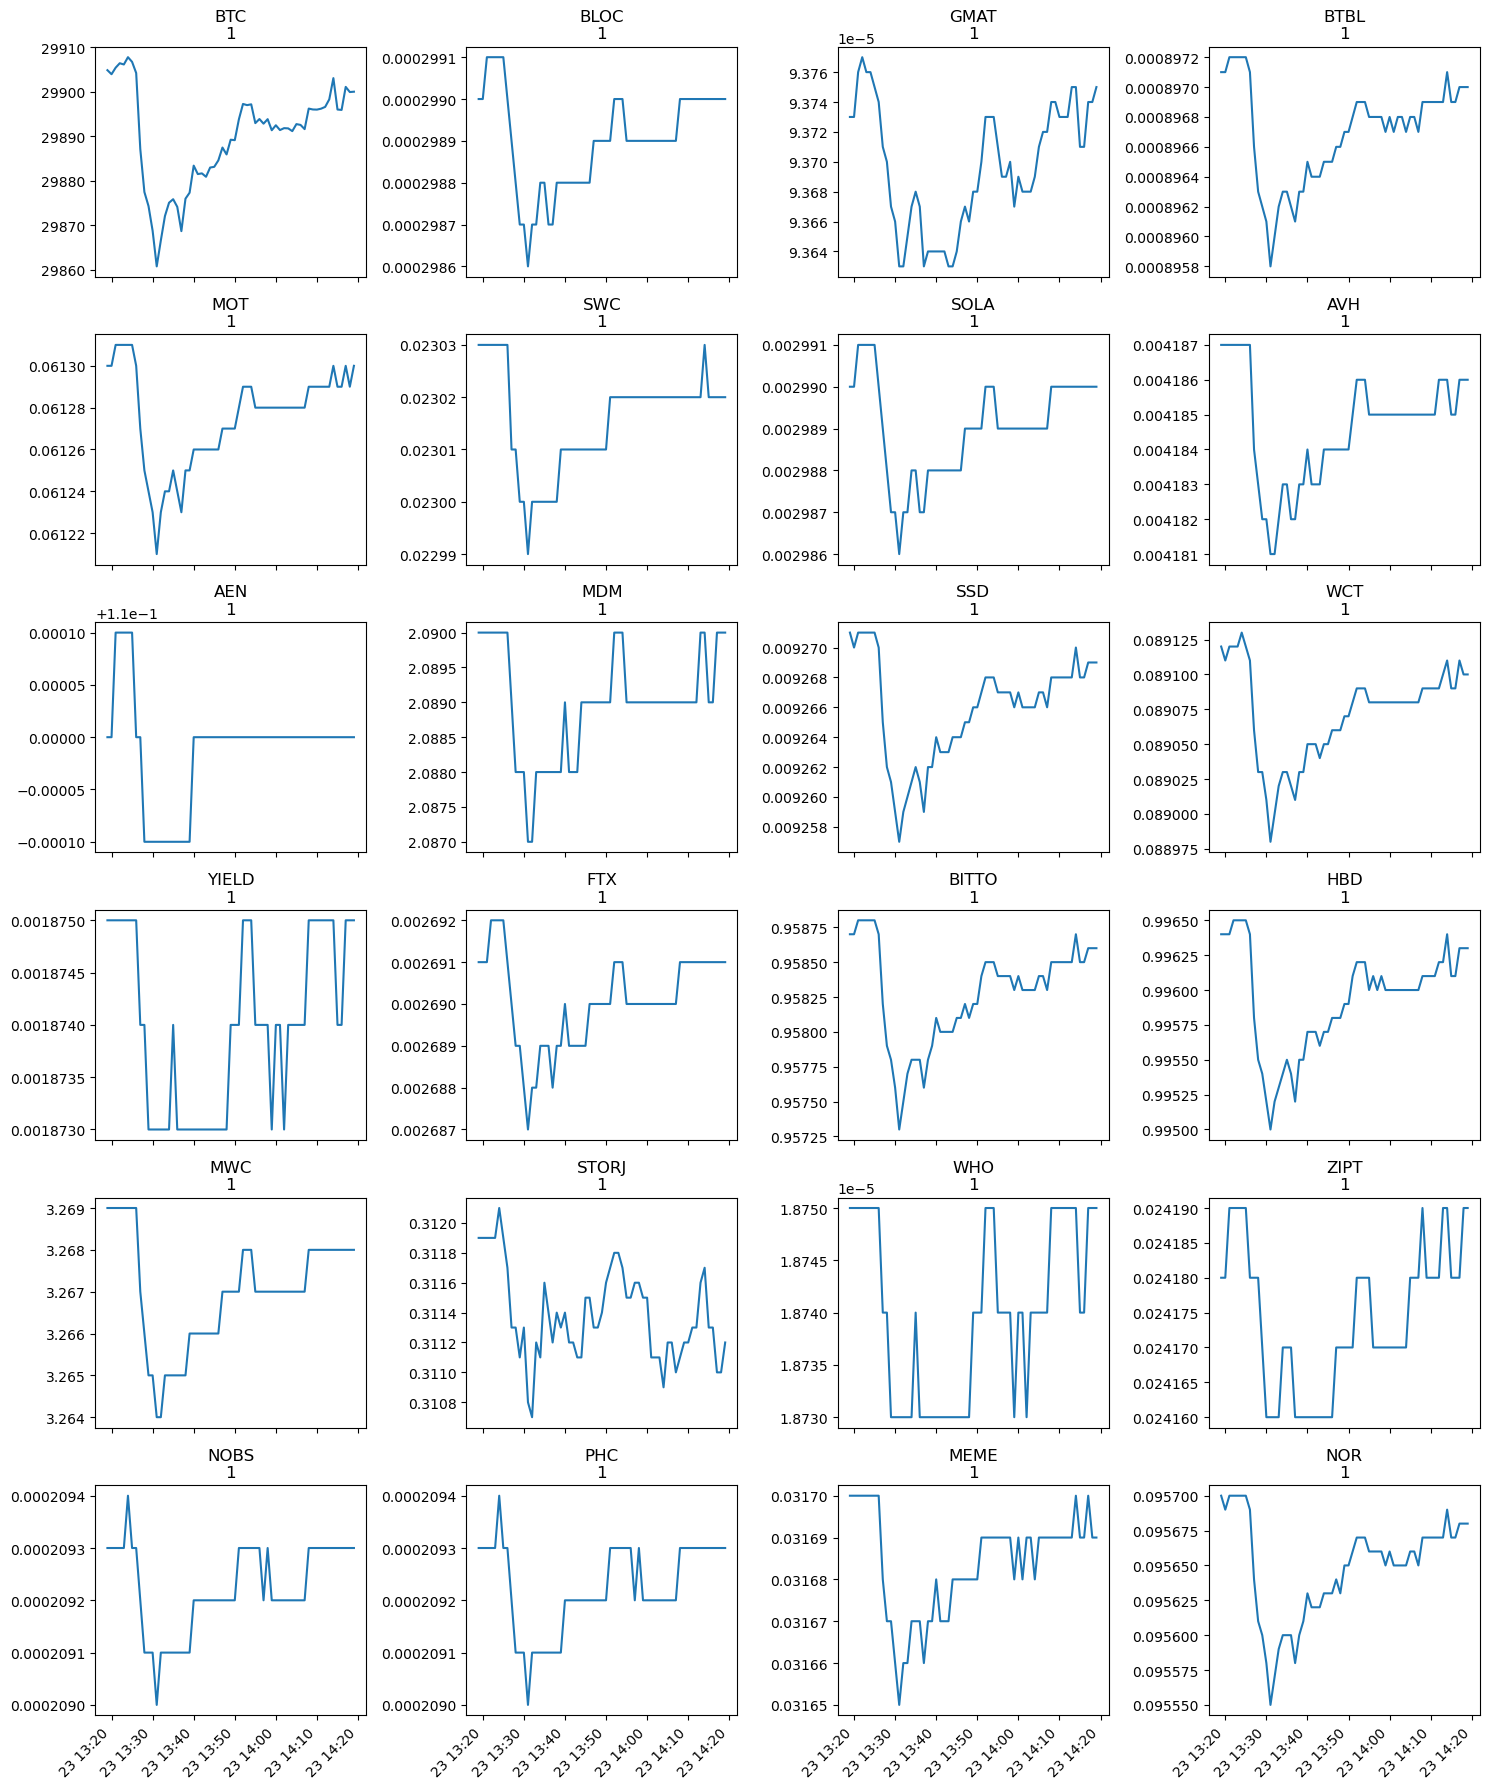

                          Cluster number: 2


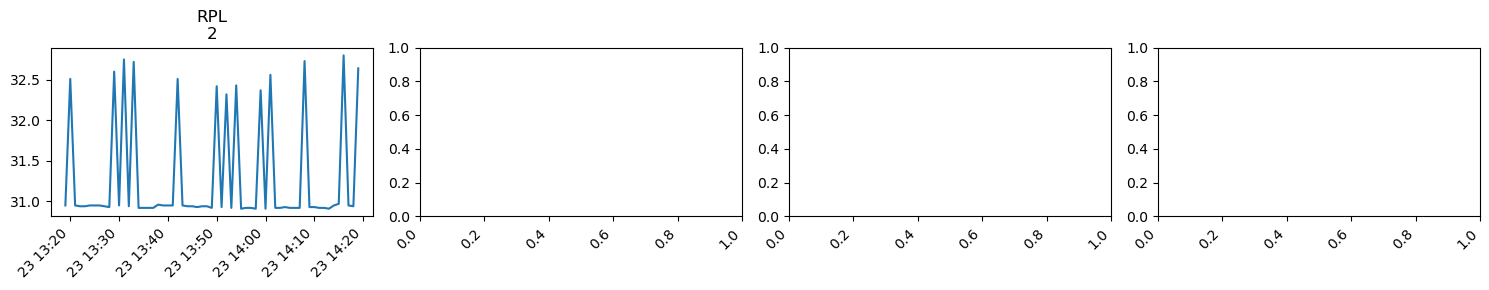

                          Cluster number: 3


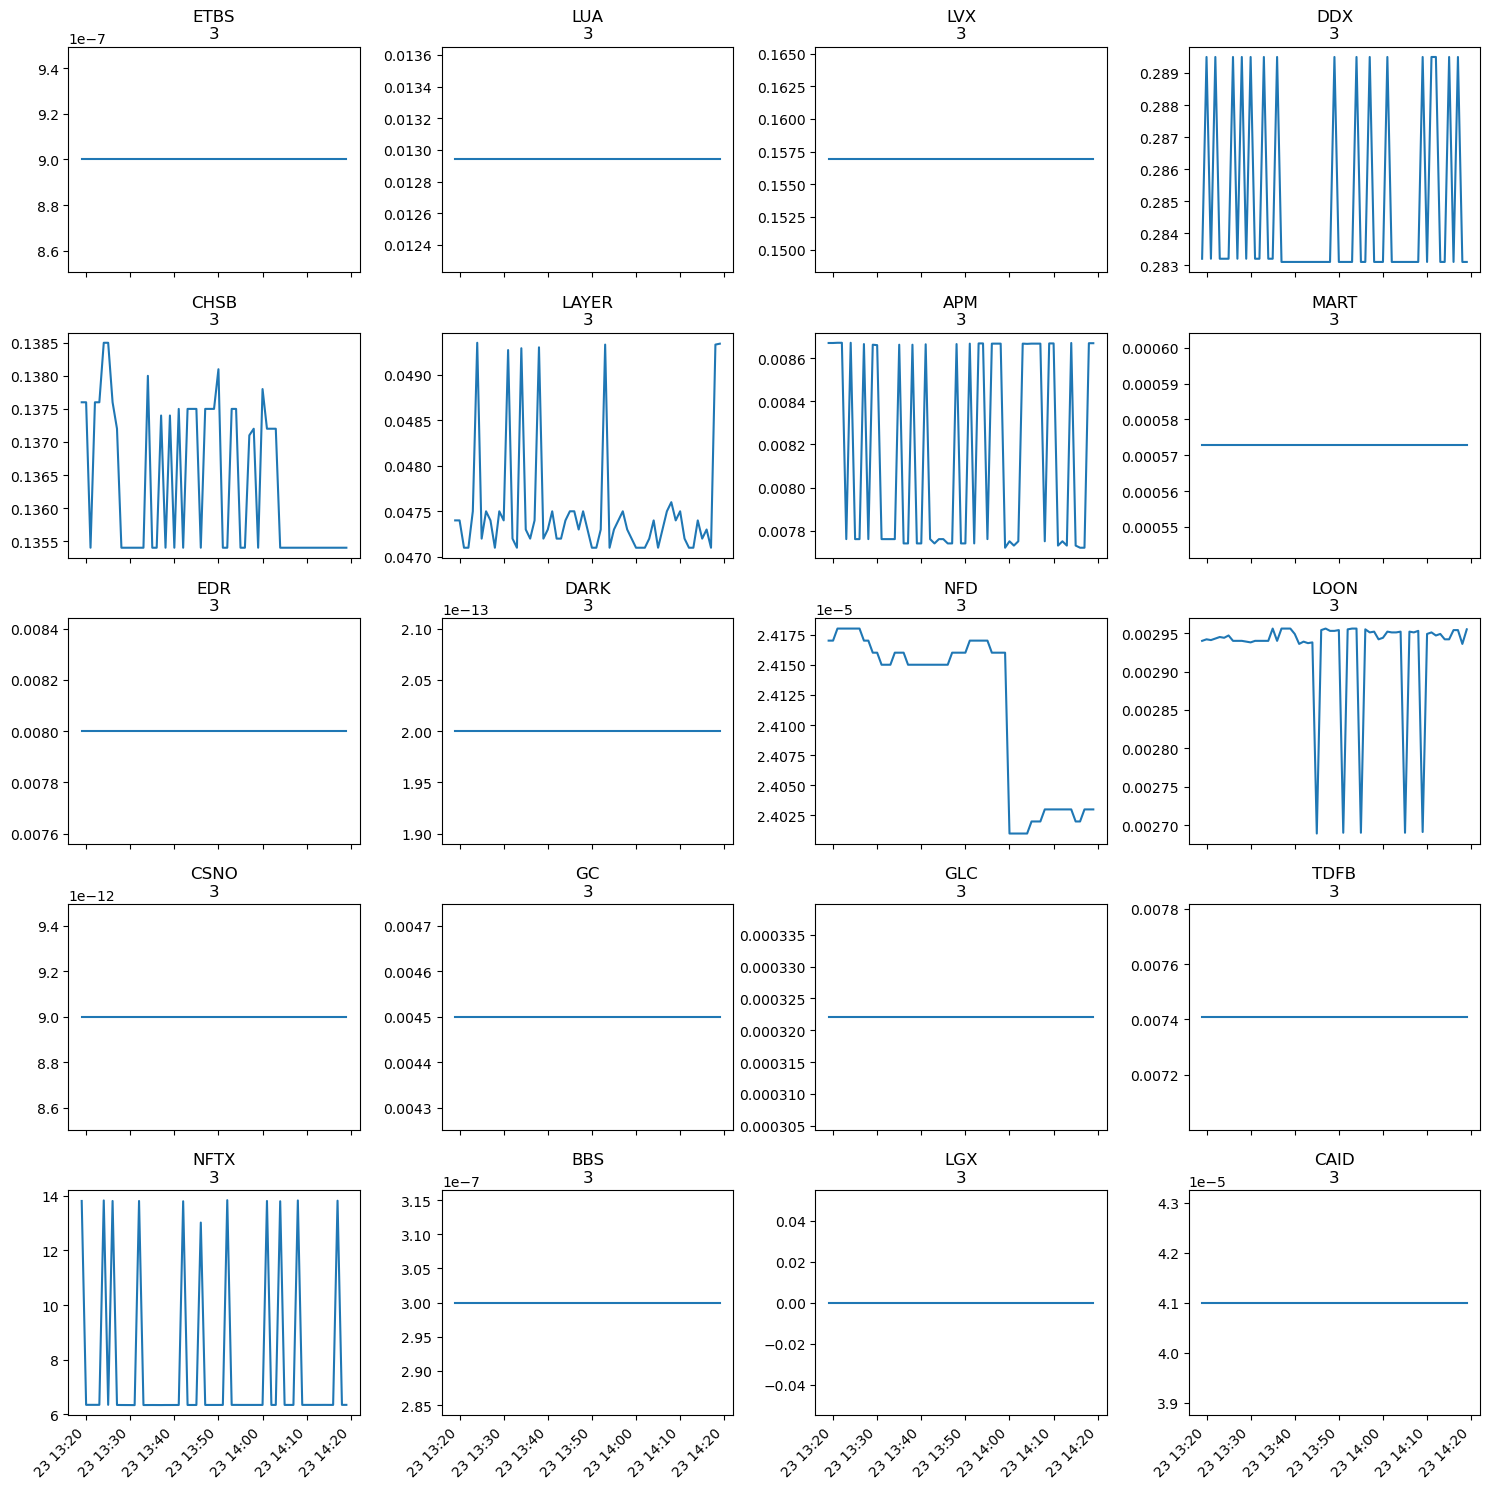

                          Cluster number: 4


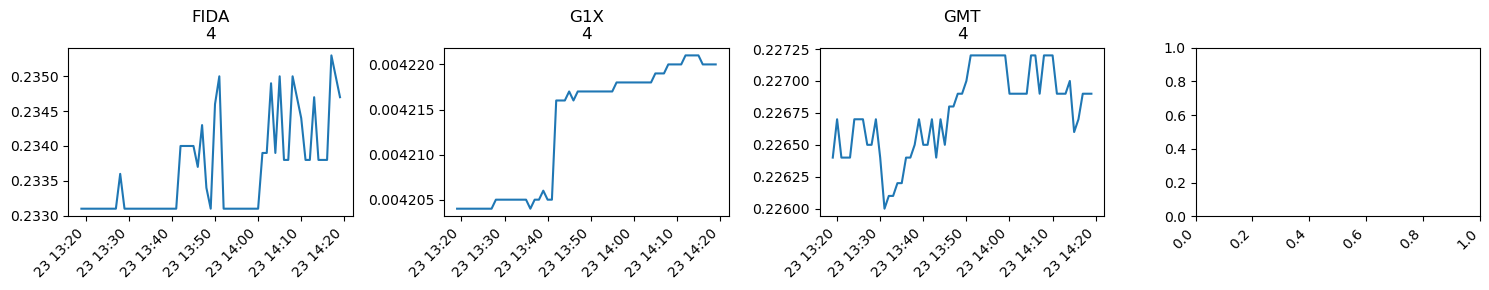

                          Cluster number: 5


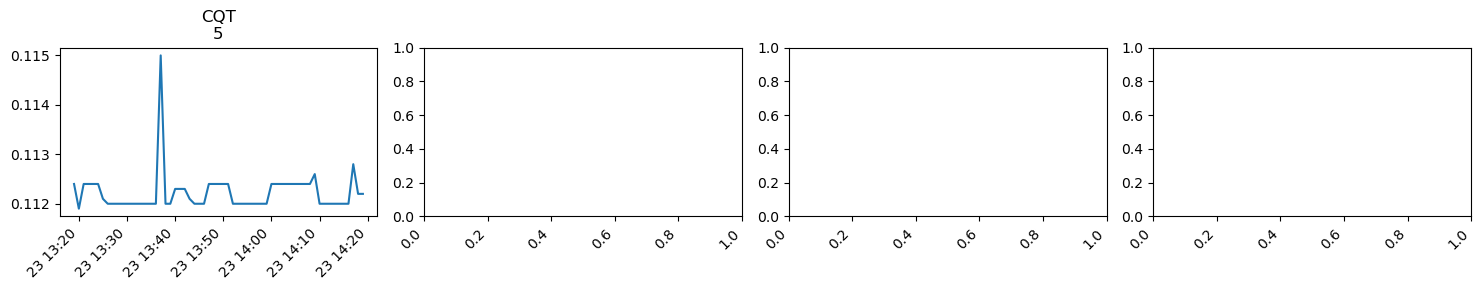

In [25]:
n_clusters = 6
ts_kmeans, df = train_and_plot_algo(n_clusters, tickers_scaled, full_ticker_df, "euclidean")
results_of_clustering['min'] = show_tikers_in_claster(df)
plot_cluster_tickers_for_clusters(df, n_clusters)

## DTW
### За последние 30 дней с дневной частотой

  0%|          | 0/1001 [00:00<?, ?it/s]

[ERROR] CCCAGG market does not exist for this coin pair (CYS-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CFXQ-USD)
[ERROR] CCCAGG market does not exist for this coin pair (OWN-USD)
[ERROR] CCCAGG market does not exist for this coin pair (FOCV-USD)
[ERROR] CCCAGG market does not exist for this coin pair (VYBE-USD)
[ERROR] You are over your rate limit please upgrade your account!
[ERROR] You are over your rate limit please upgrade your account!
[ERROR] You are over your rate limit please upgrade your account!
[ERROR] You are over your rate limit please upgrade your account!
[ERROR] You are over your rate limit please upgrade your account!
[ERROR] You are over your rate limit please upgrade your account!
[ERROR] You are over your rate limit please upgrade your account!
[ERROR] You are over your rate limit please upgrade your account!
[ERROR] You are over your rate limit please upgrade your account!
[ERROR] You are over your rate limit please upgrade your account!
[ERROR]

  0%|          | 0/8 [00:00<?, ?it/s]

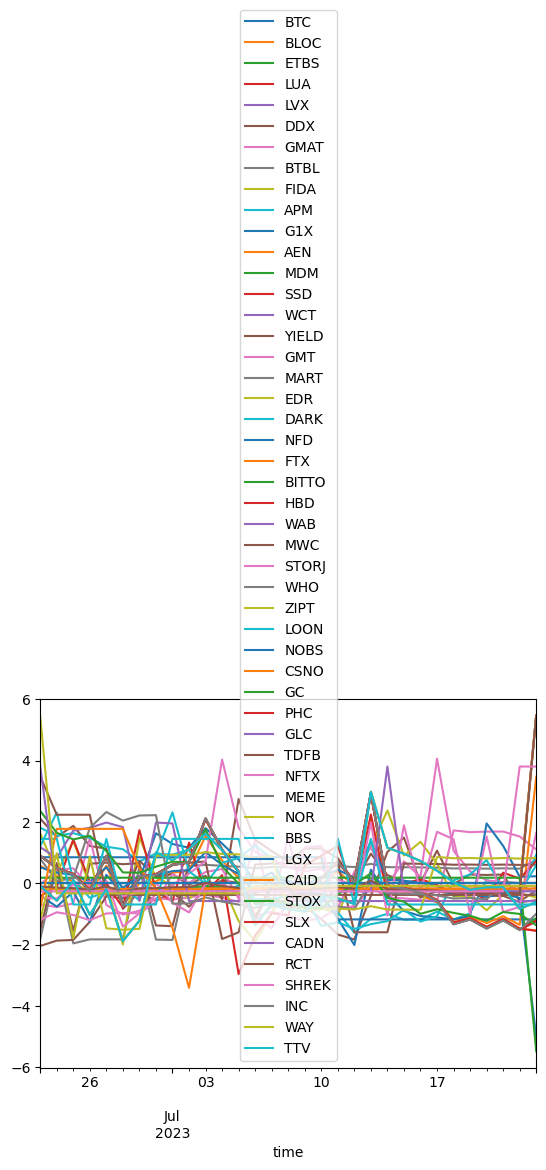

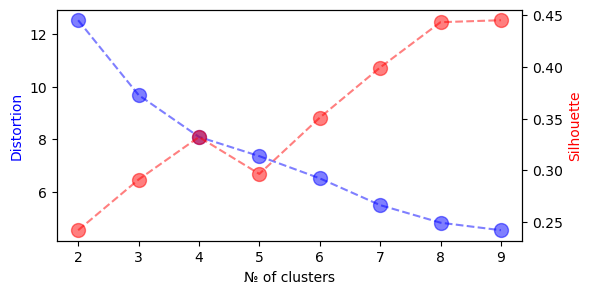

In [26]:
full_ticker_df = get_full_ticker_df('day', cripto_list_sample, 50)
tickers_scaled = scale_and_plot_ticker_df(full_ticker_df)
plot_clustering_metrics(tickers_scaled, "dtw")

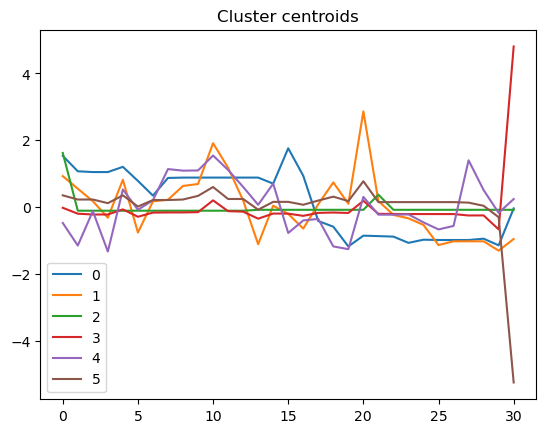

C:\Users\oleg\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 50 1-dimensional timeseries
  warnings.warn(


                          Cluster number: 0


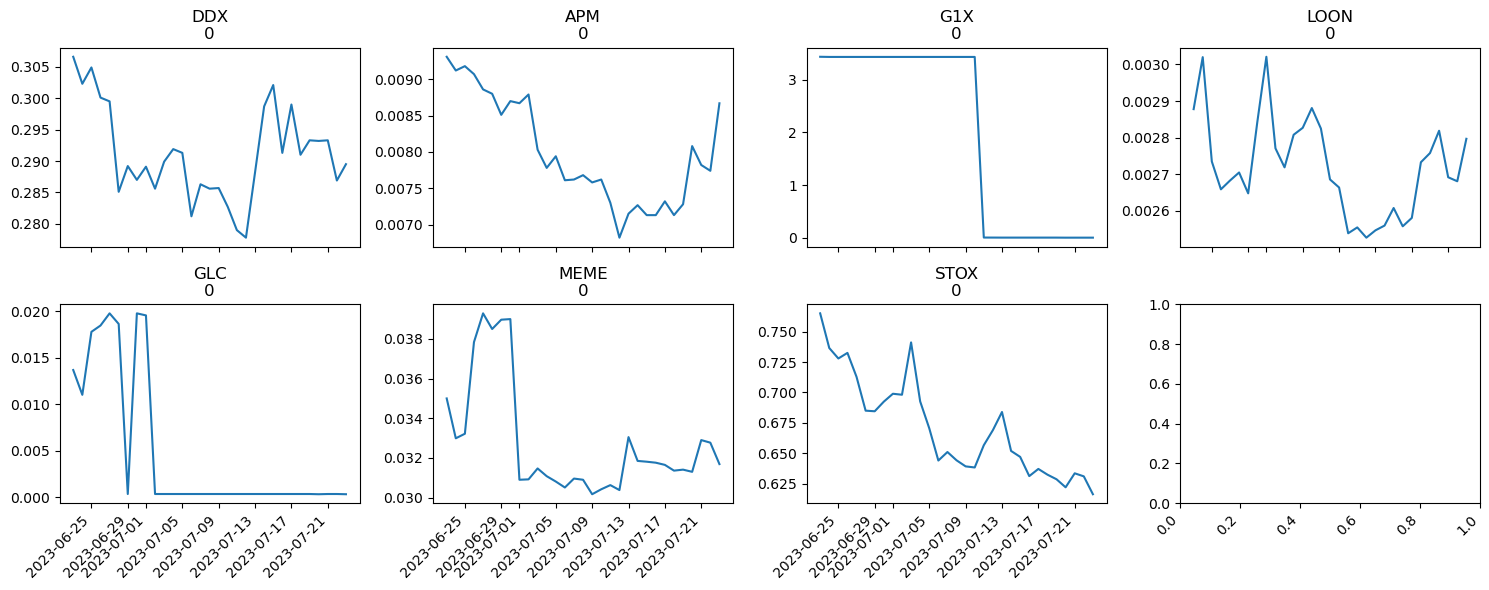

                          Cluster number: 1


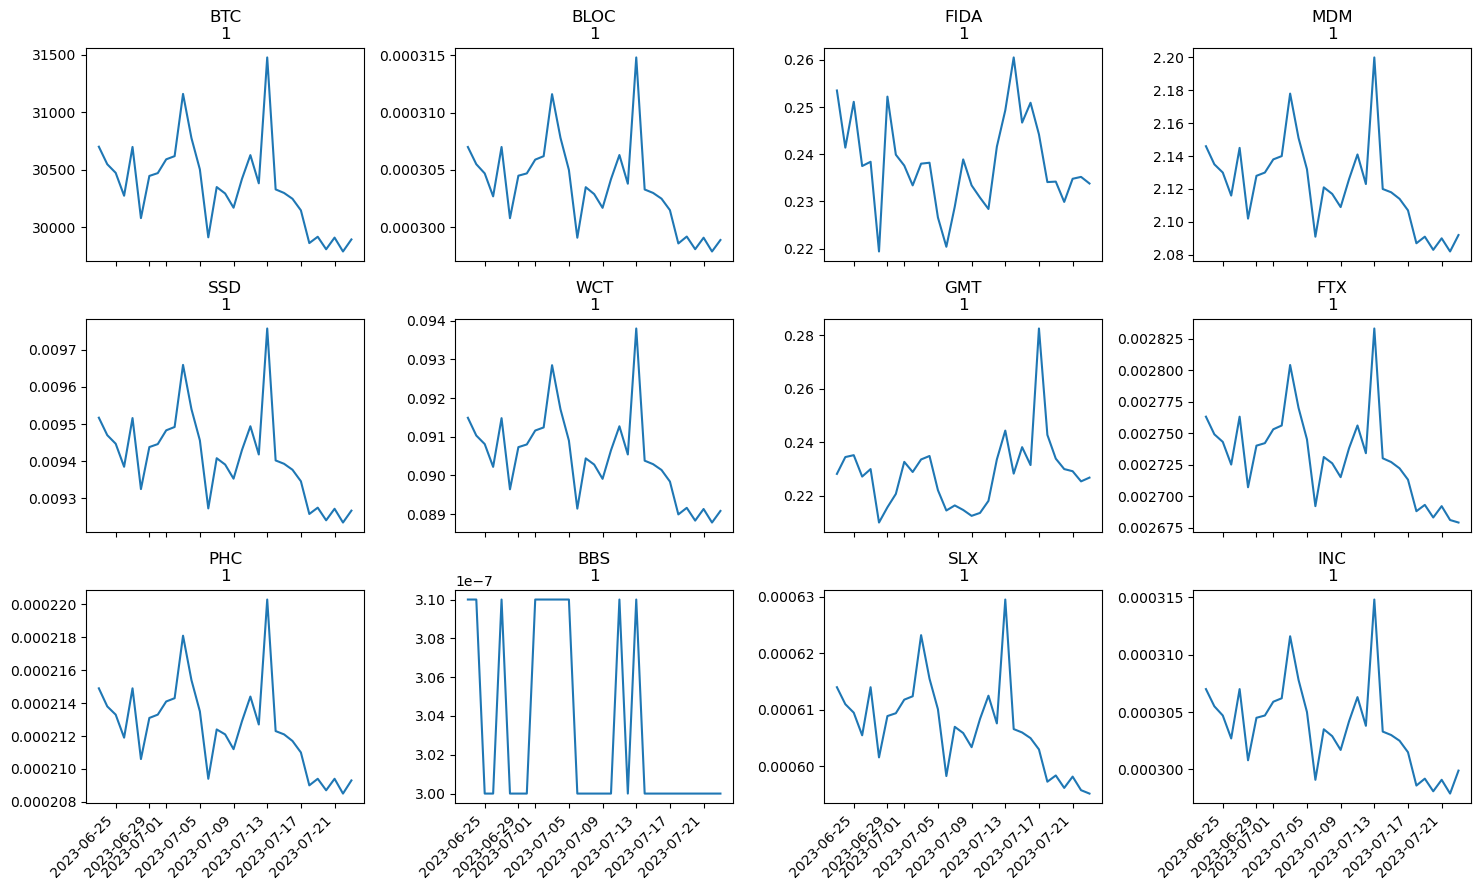

                          Cluster number: 2


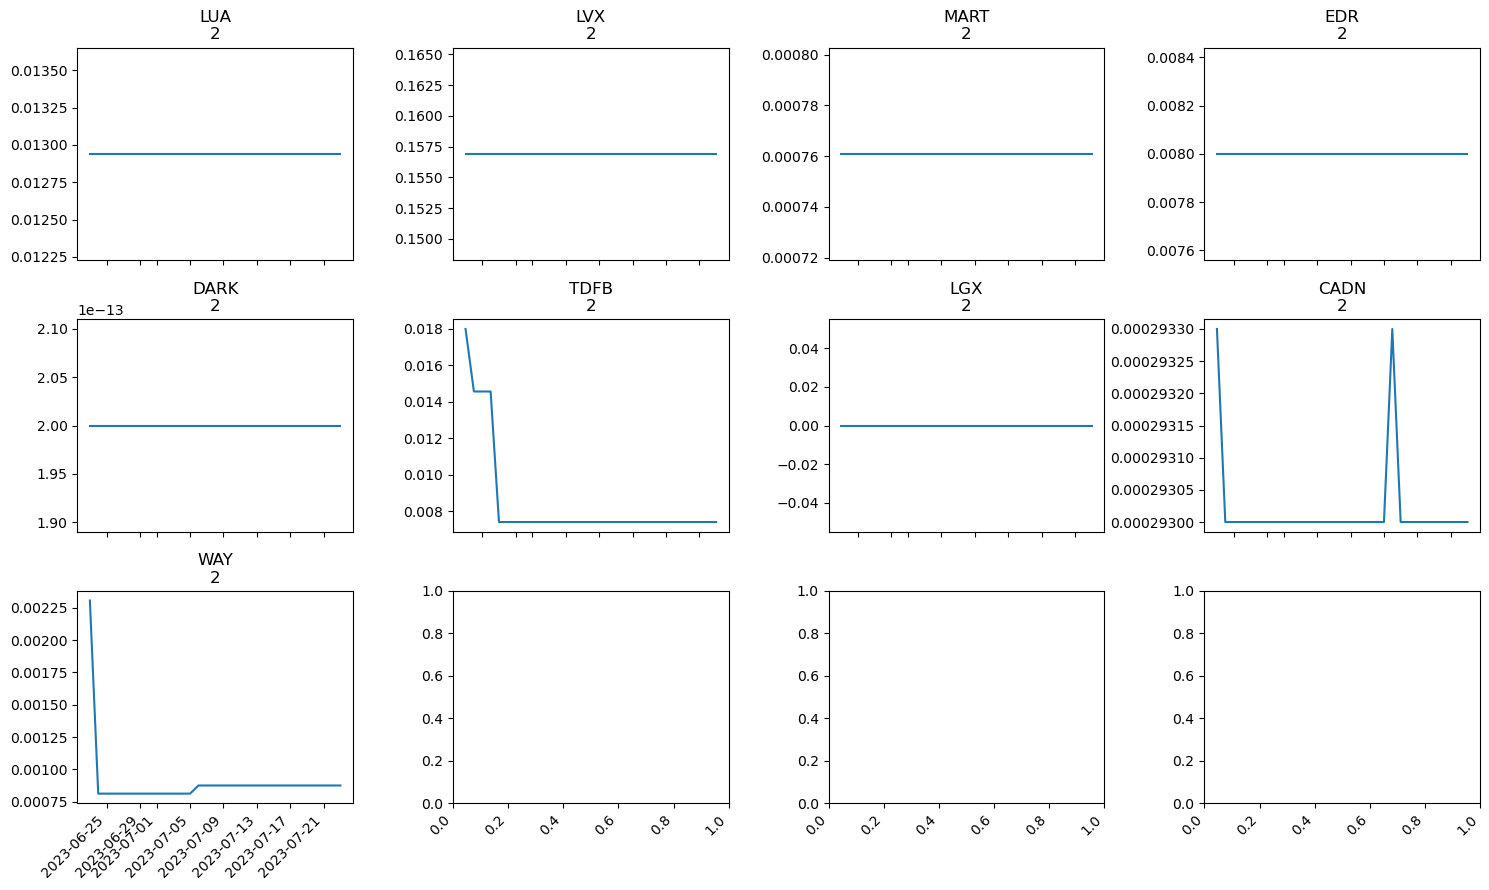

                          Cluster number: 3


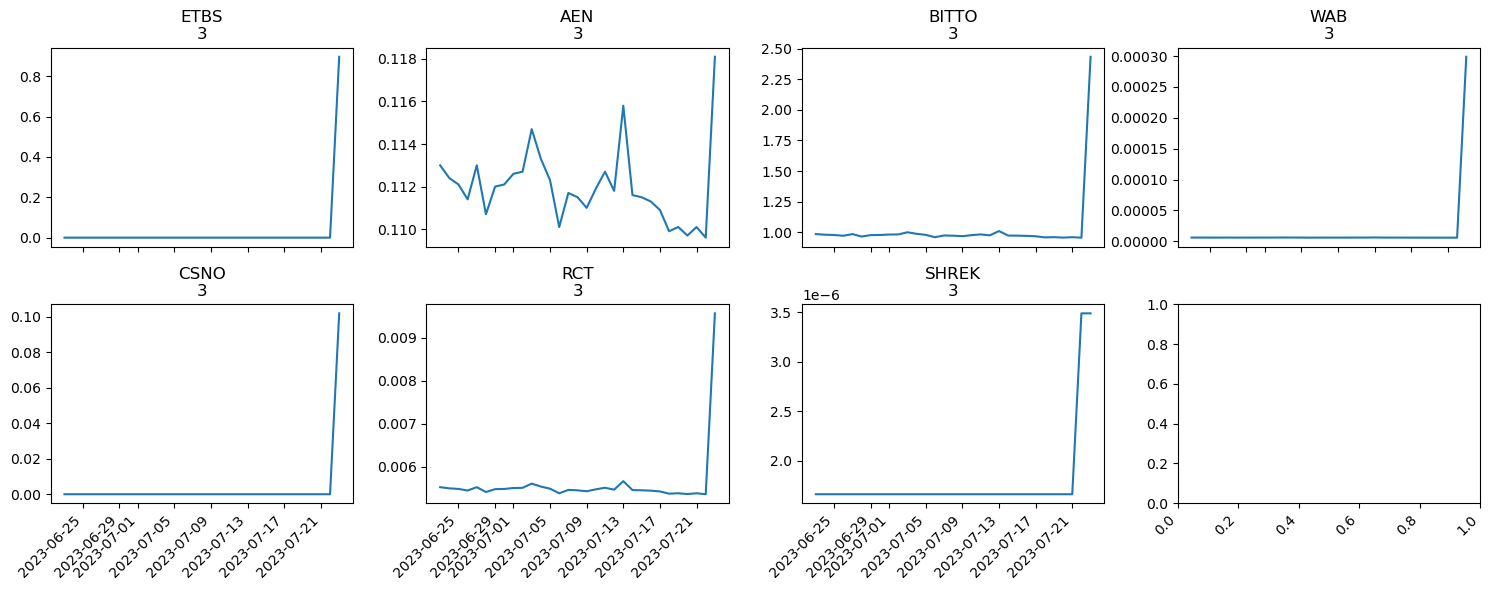

                          Cluster number: 4


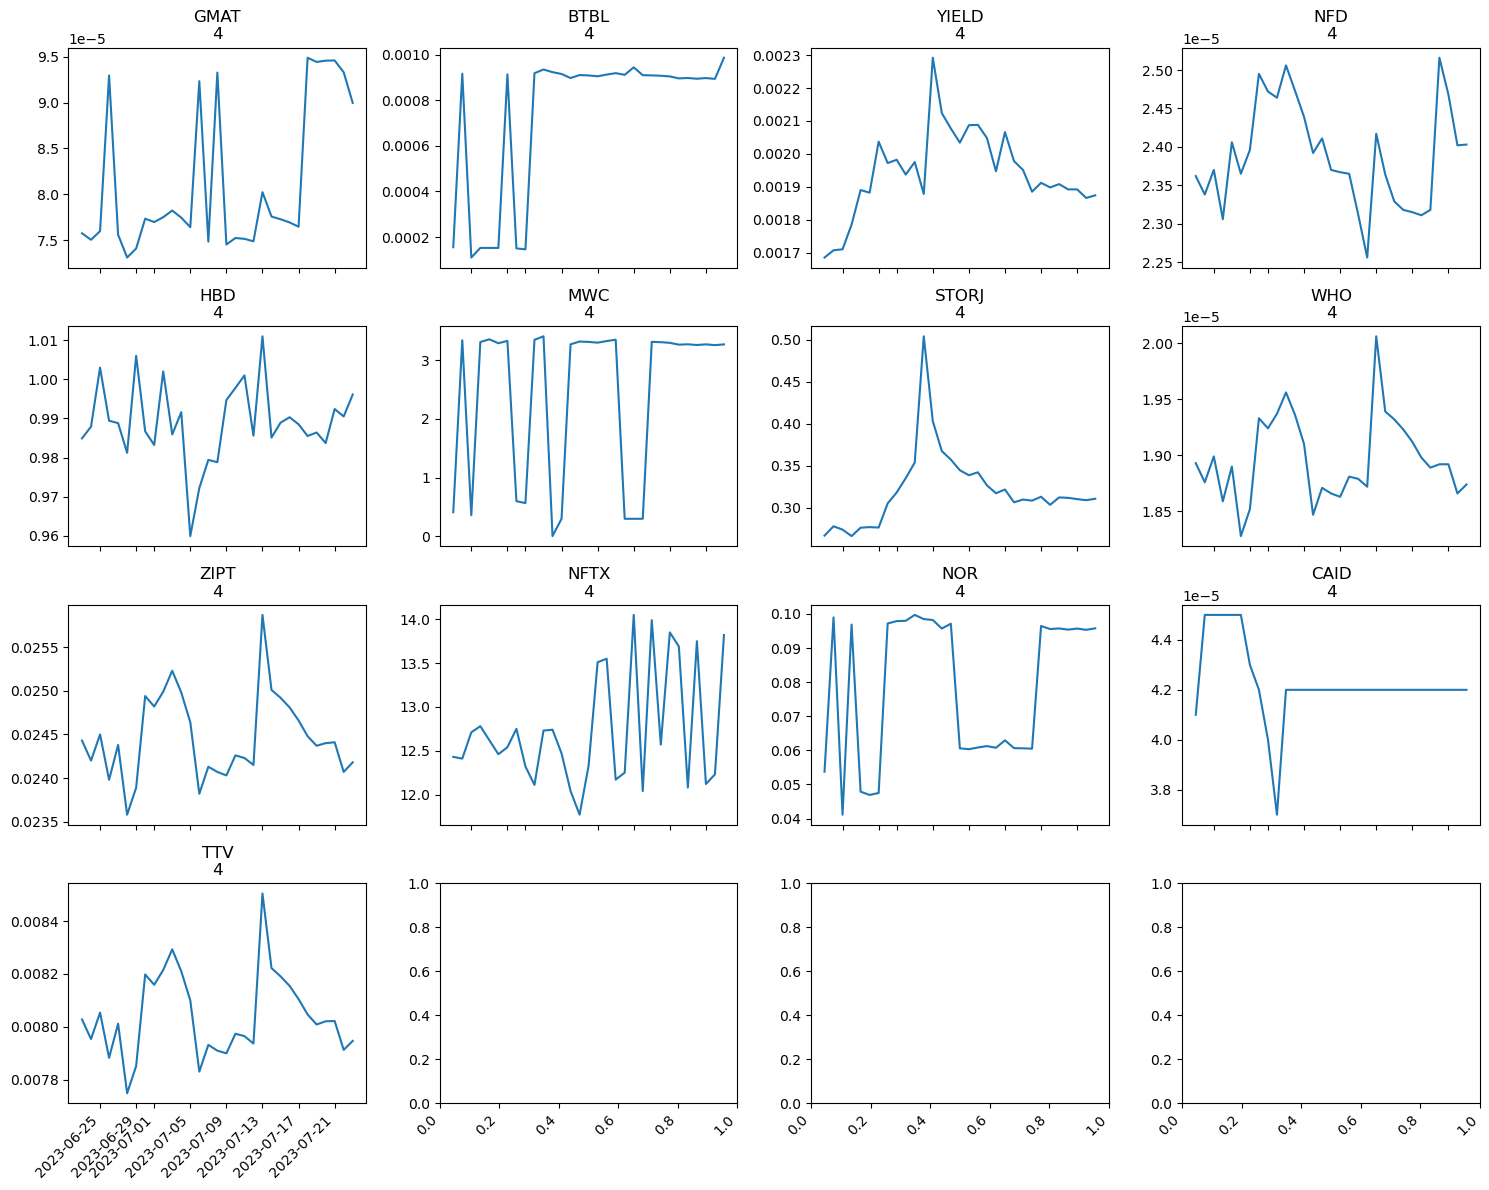

                          Cluster number: 5


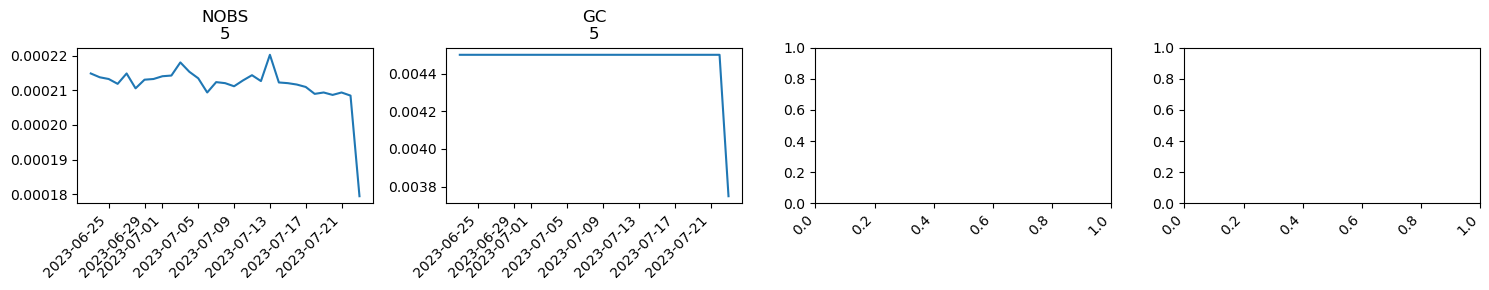

In [27]:
n_clusters = 6
ts_kmeans, df = train_and_plot_algo(n_clusters, tickers_scaled, full_ticker_df, "dtw")
results_of_clustering['day_dtw'] = show_tikers_in_claster(df)
plot_cluster_tickers_for_clusters(df, n_clusters)

### За последние 3 дня с часовой частотой

  0%|          | 0/1001 [00:00<?, ?it/s]

[ERROR] CCCAGG market does not exist for this coin pair (CYS-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CFXQ-USD)
[ERROR] CCCAGG market does not exist for this coin pair (OWN-USD)
[ERROR] CCCAGG market does not exist for this coin pair (FOCV-USD)
[ERROR] CCCAGG market does not exist for this coin pair (VYBE-USD)
[ERROR] CCCAGG market does not exist for this coin pair (GFCE-USD)
[ERROR] CCCAGG market does not exist for this coin pair (NEXBT-USD)
[ERROR] CCCAGG market does not exist for this coin pair (NXD-USD)
[ERROR] CCCAGG market does not exist for this coin pair (BPRIVA-USD)
[ERROR] CCCAGG market does not exist for this coin pair (GOFX-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CALC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (POSTC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (XDAG-USD)
[ERROR] CCCAGG market does not exist for this coin pair (DINU-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CBOT

  0%|          | 0/8 [00:00<?, ?it/s]

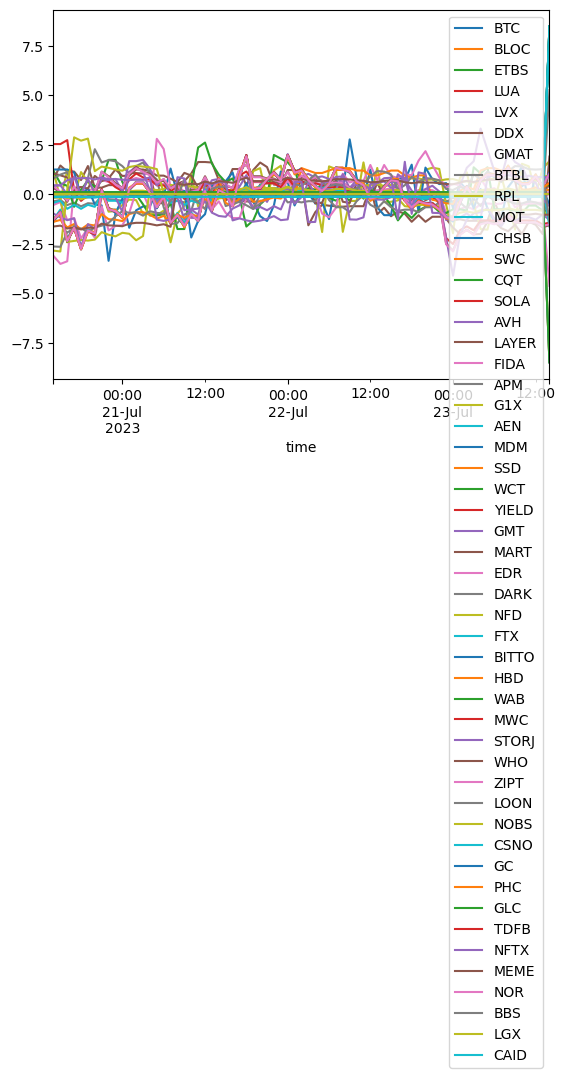

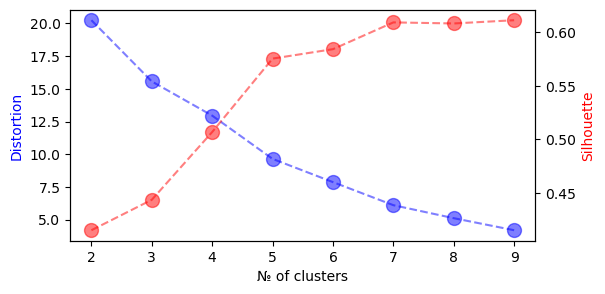

In [28]:
full_ticker_df = get_full_ticker_df('hour', cripto_list_sample, 50)
tickers_scaled = scale_and_plot_ticker_df(full_ticker_df)
plot_clustering_metrics(tickers_scaled, "dtw")

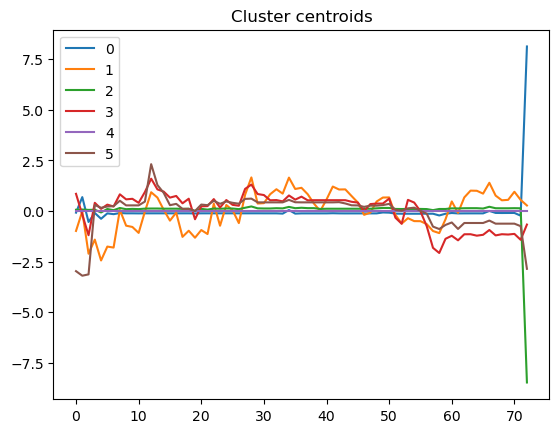

C:\Users\oleg\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 50 1-dimensional timeseries
  warnings.warn(


                          Cluster number: 0


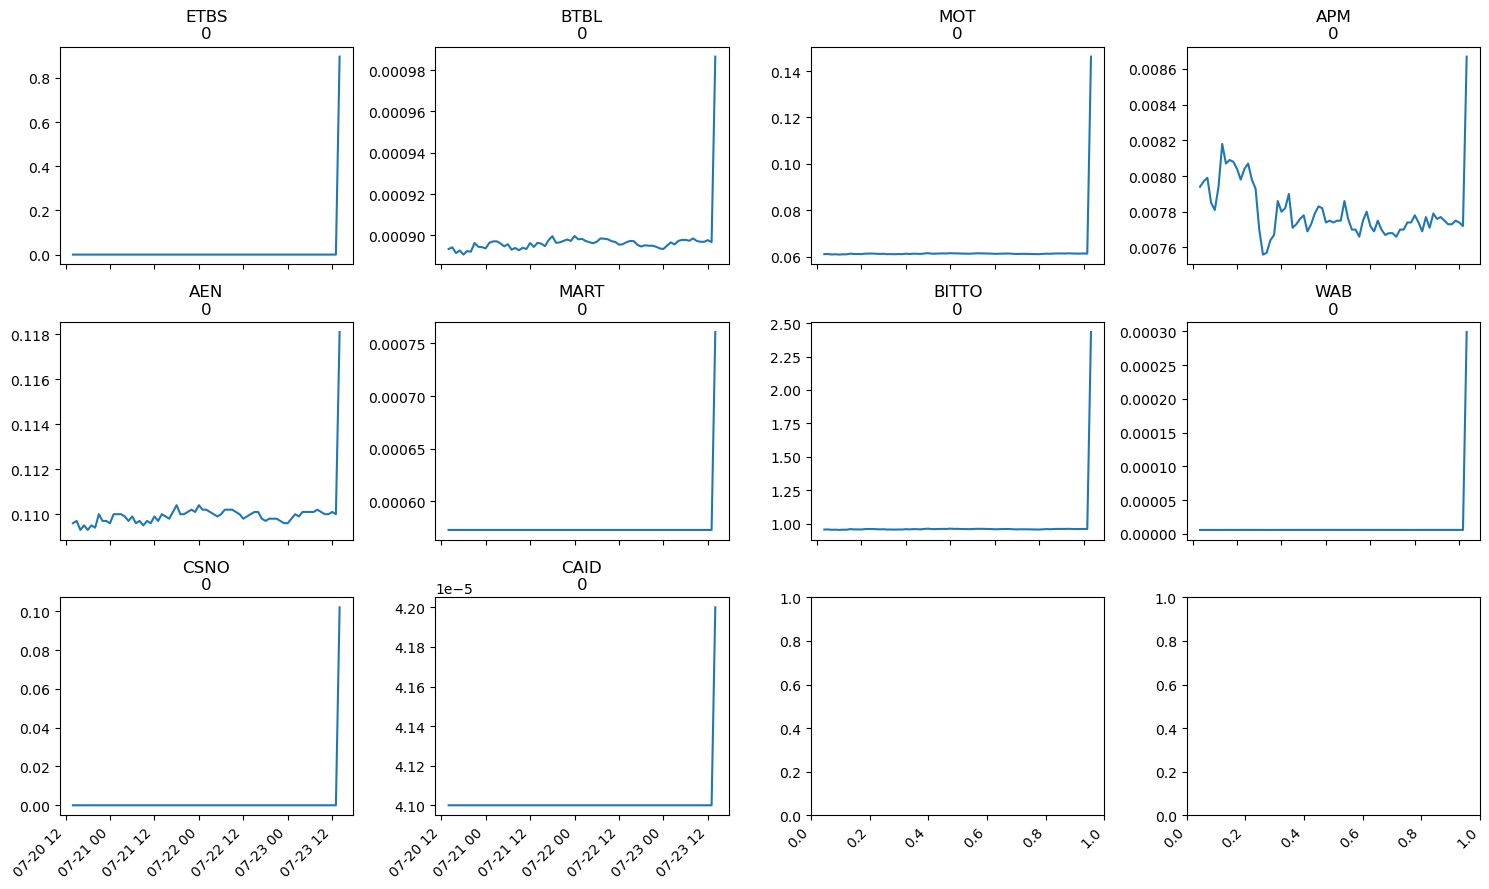

                          Cluster number: 1


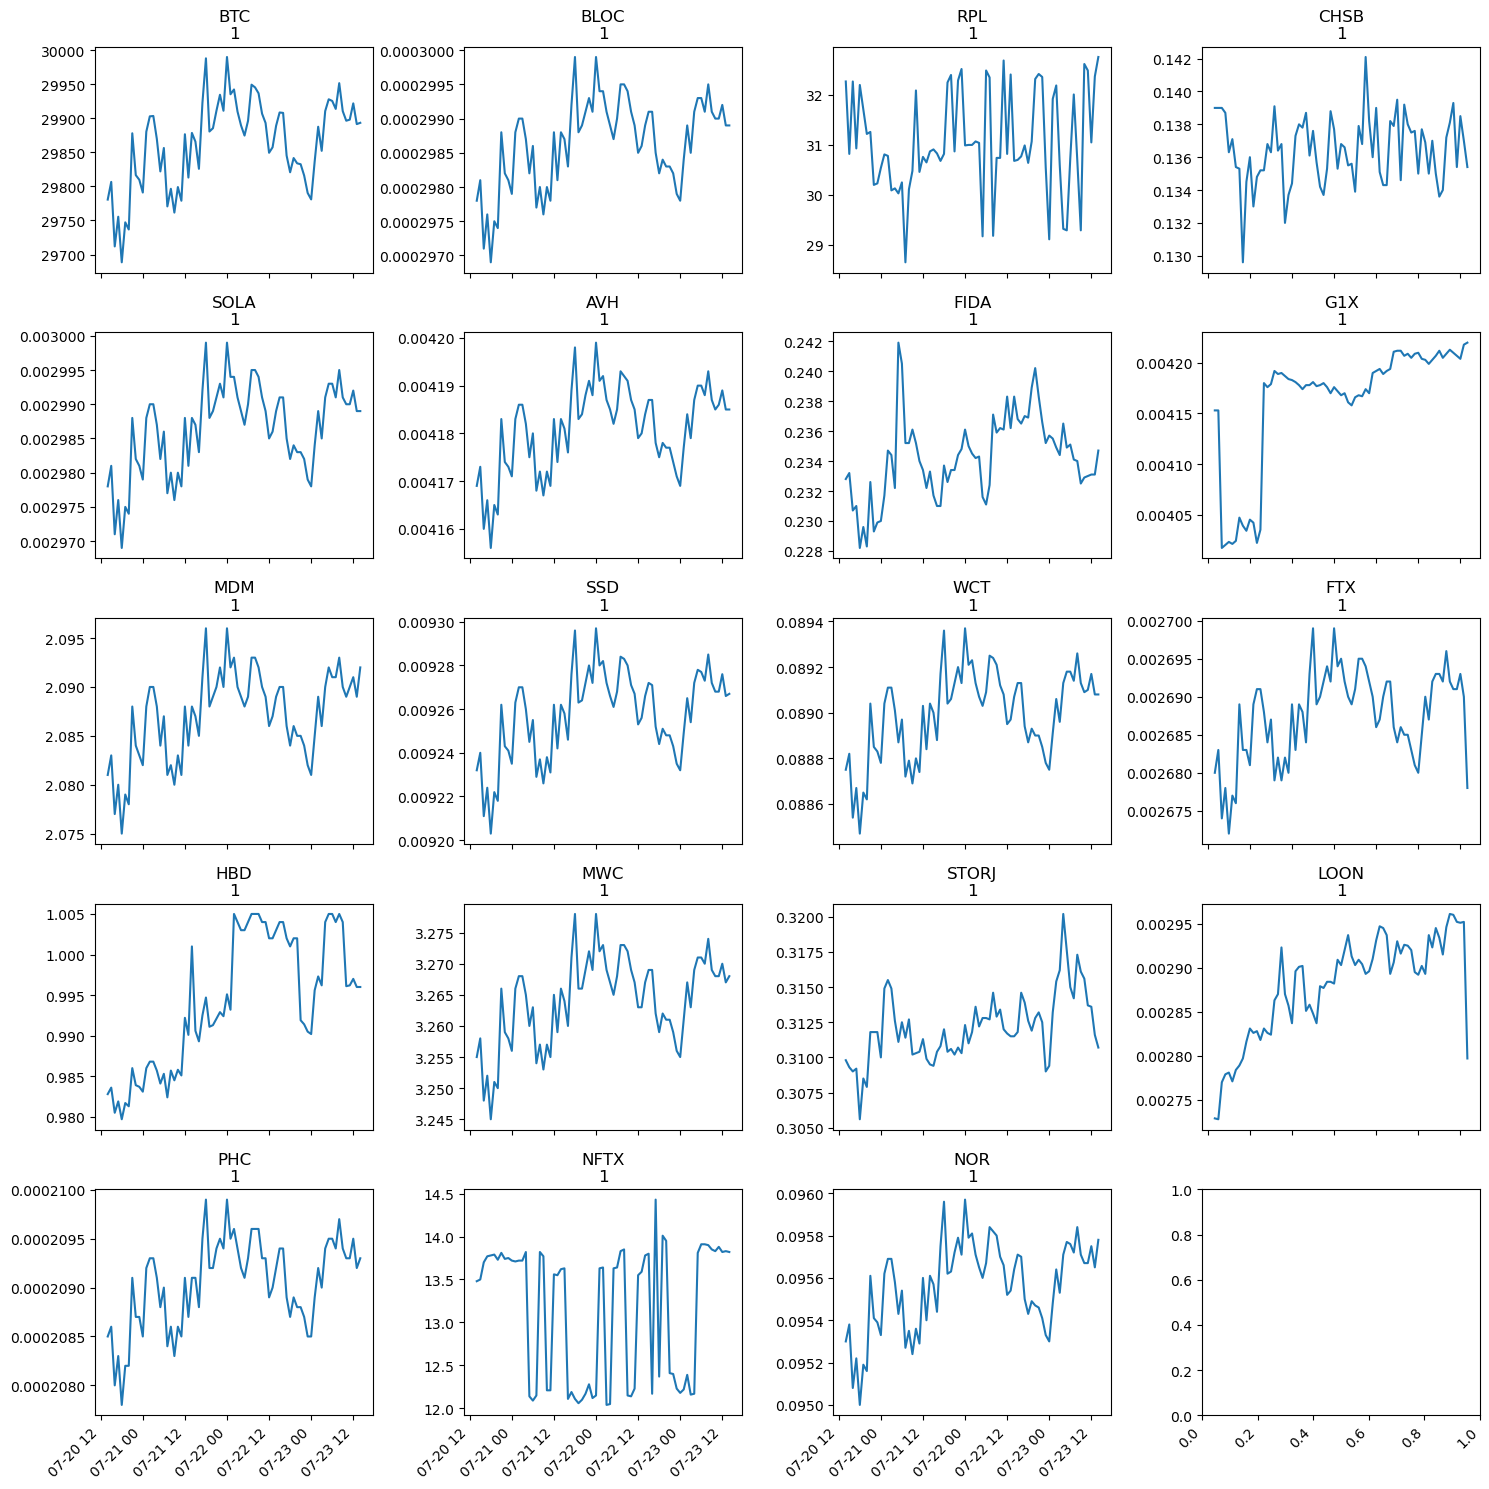

                          Cluster number: 2


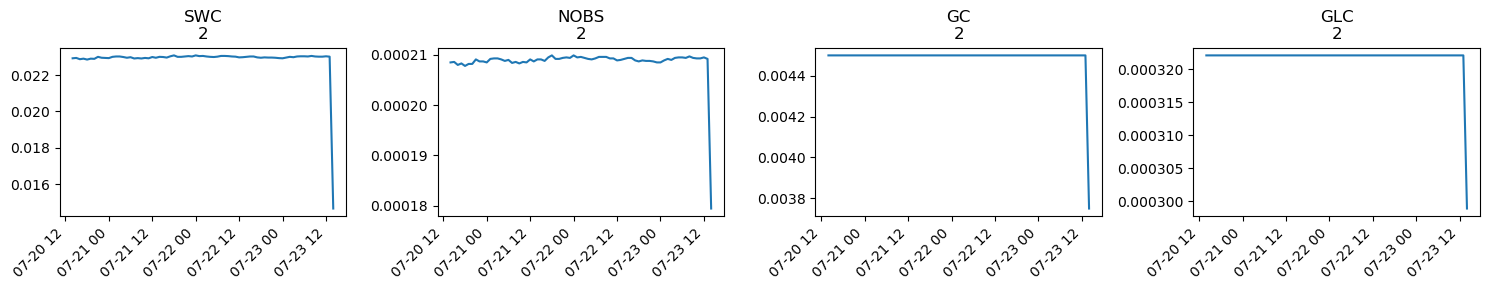

                          Cluster number: 3


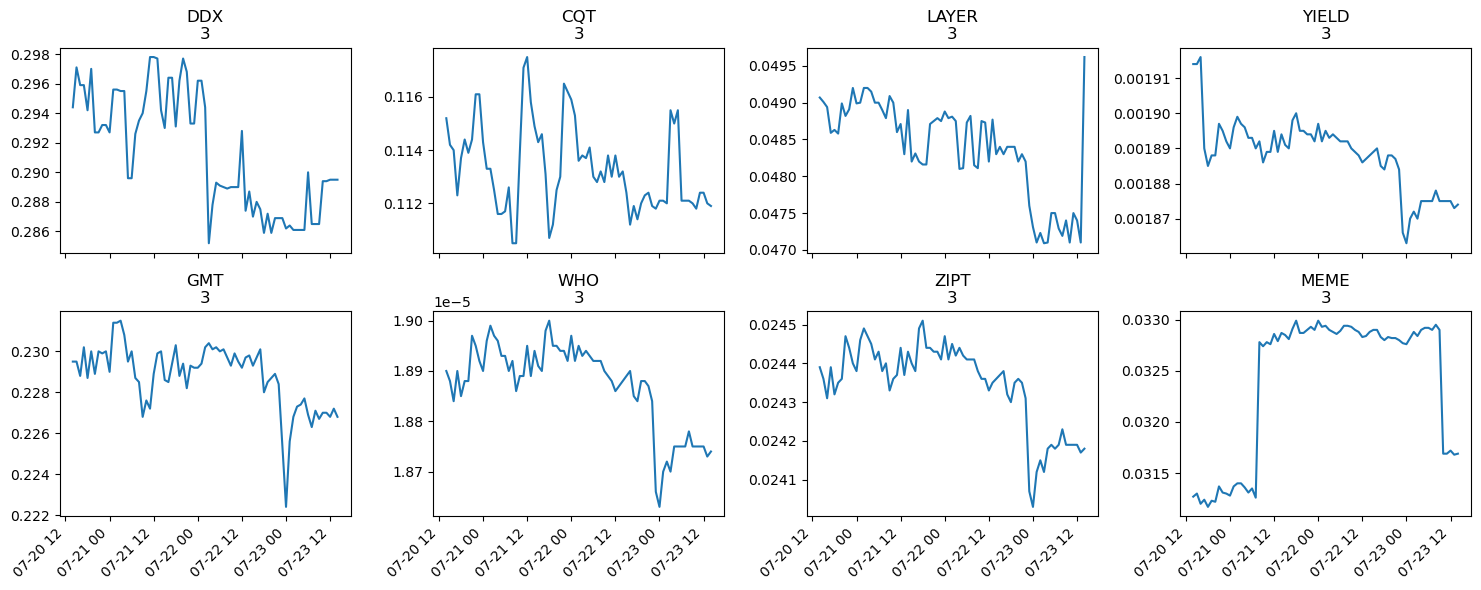

                          Cluster number: 4


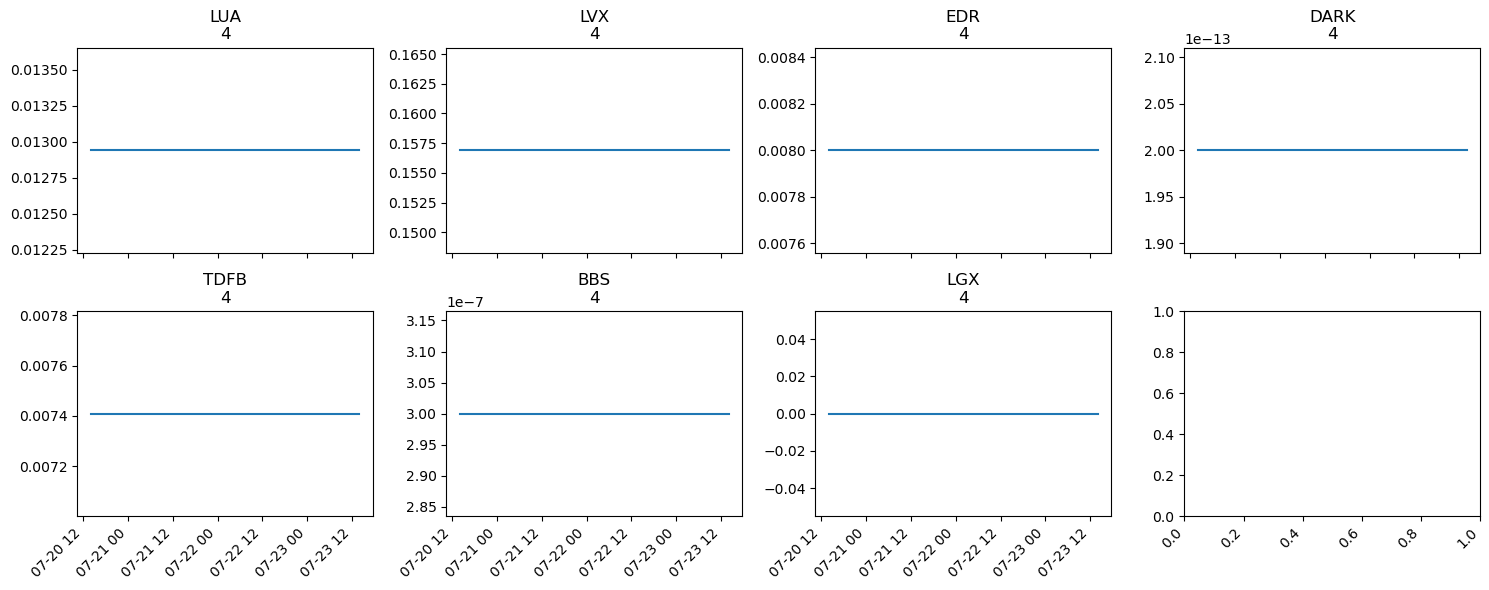

                          Cluster number: 5


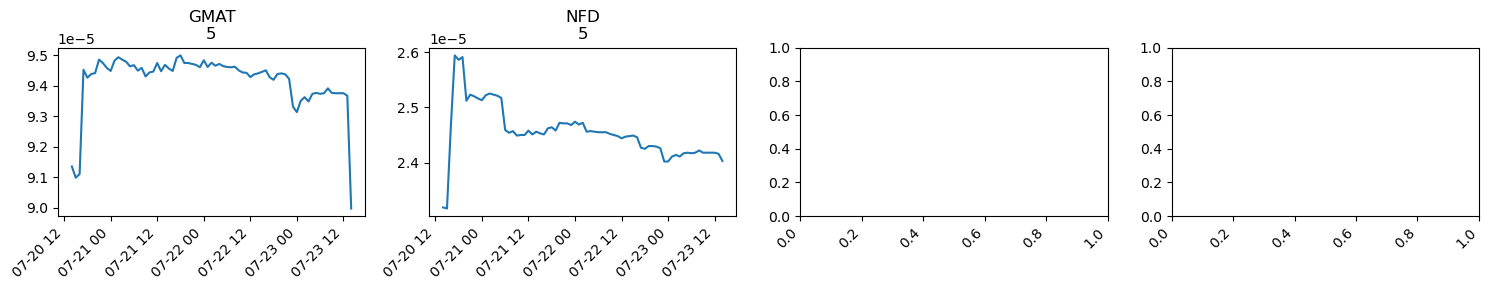

In [29]:
n_clusters = 6
ts_kmeans, df = train_and_plot_algo(n_clusters, tickers_scaled, full_ticker_df, "dtw")
results_of_clustering['hour_dtw'] = show_tikers_in_claster(df)
plot_cluster_tickers_for_clusters(df, n_clusters)

### За последний час с минутной частотой

  0%|          | 0/1001 [00:00<?, ?it/s]

[ERROR] CCCAGG market does not exist for this coin pair (CYS-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CFXQ-USD)
[ERROR] CCCAGG market does not exist for this coin pair (OWN-USD)
[ERROR] CCCAGG market does not exist for this coin pair (FOCV-USD)
[ERROR] CCCAGG market does not exist for this coin pair (VYBE-USD)
[ERROR] CCCAGG market does not exist for this coin pair (GFCE-USD)
[ERROR] CCCAGG market does not exist for this coin pair (NEXBT-USD)
[ERROR] CCCAGG market does not exist for this coin pair (NXD-USD)
[ERROR] CCCAGG market does not exist for this coin pair (BPRIVA-USD)
[ERROR] CCCAGG market does not exist for this coin pair (GOFX-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CALC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (POSTC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (XDAG-USD)
[ERROR] CCCAGG market does not exist for this coin pair (DINU-USD)
[ERROR] CCCAGG market does not exist for this coin pair (CBOT

  0%|          | 0/8 [00:00<?, ?it/s]

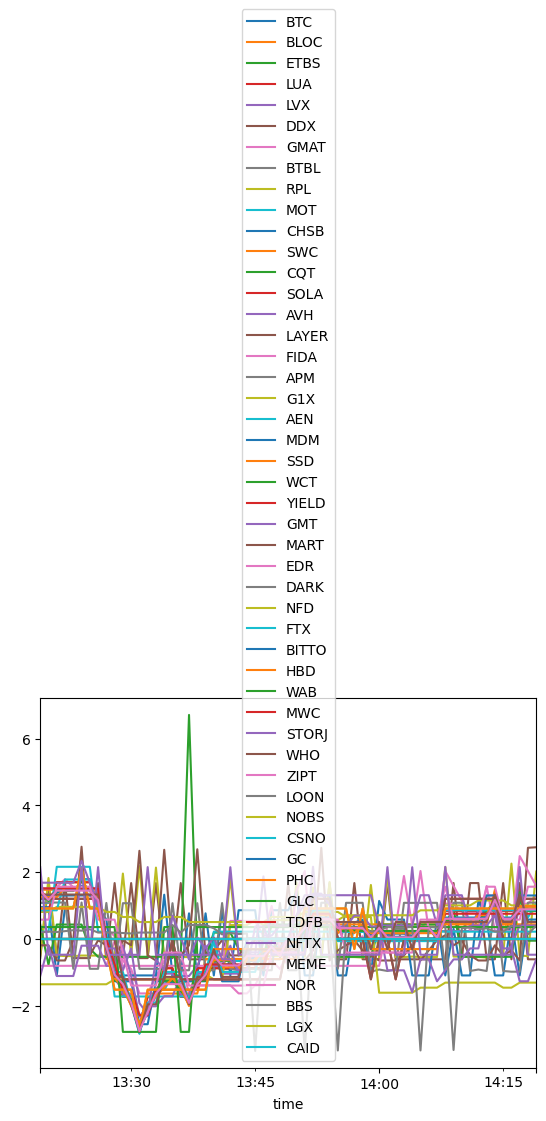

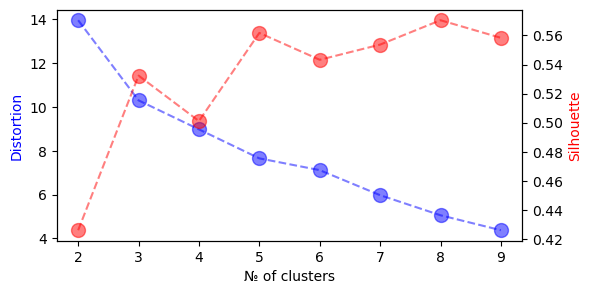

In [30]:
full_ticker_df = get_full_ticker_df('min', cripto_list_sample, 50)
tickers_scaled = scale_and_plot_ticker_df(full_ticker_df)
plot_clustering_metrics(tickers_scaled, "dtw")

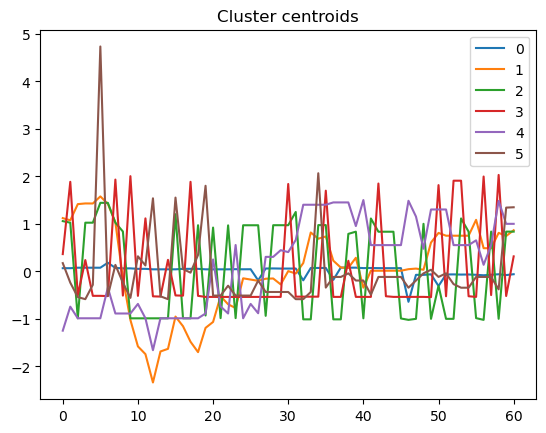

C:\Users\oleg\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 50 1-dimensional timeseries
  warnings.warn(


                          Cluster number: 0


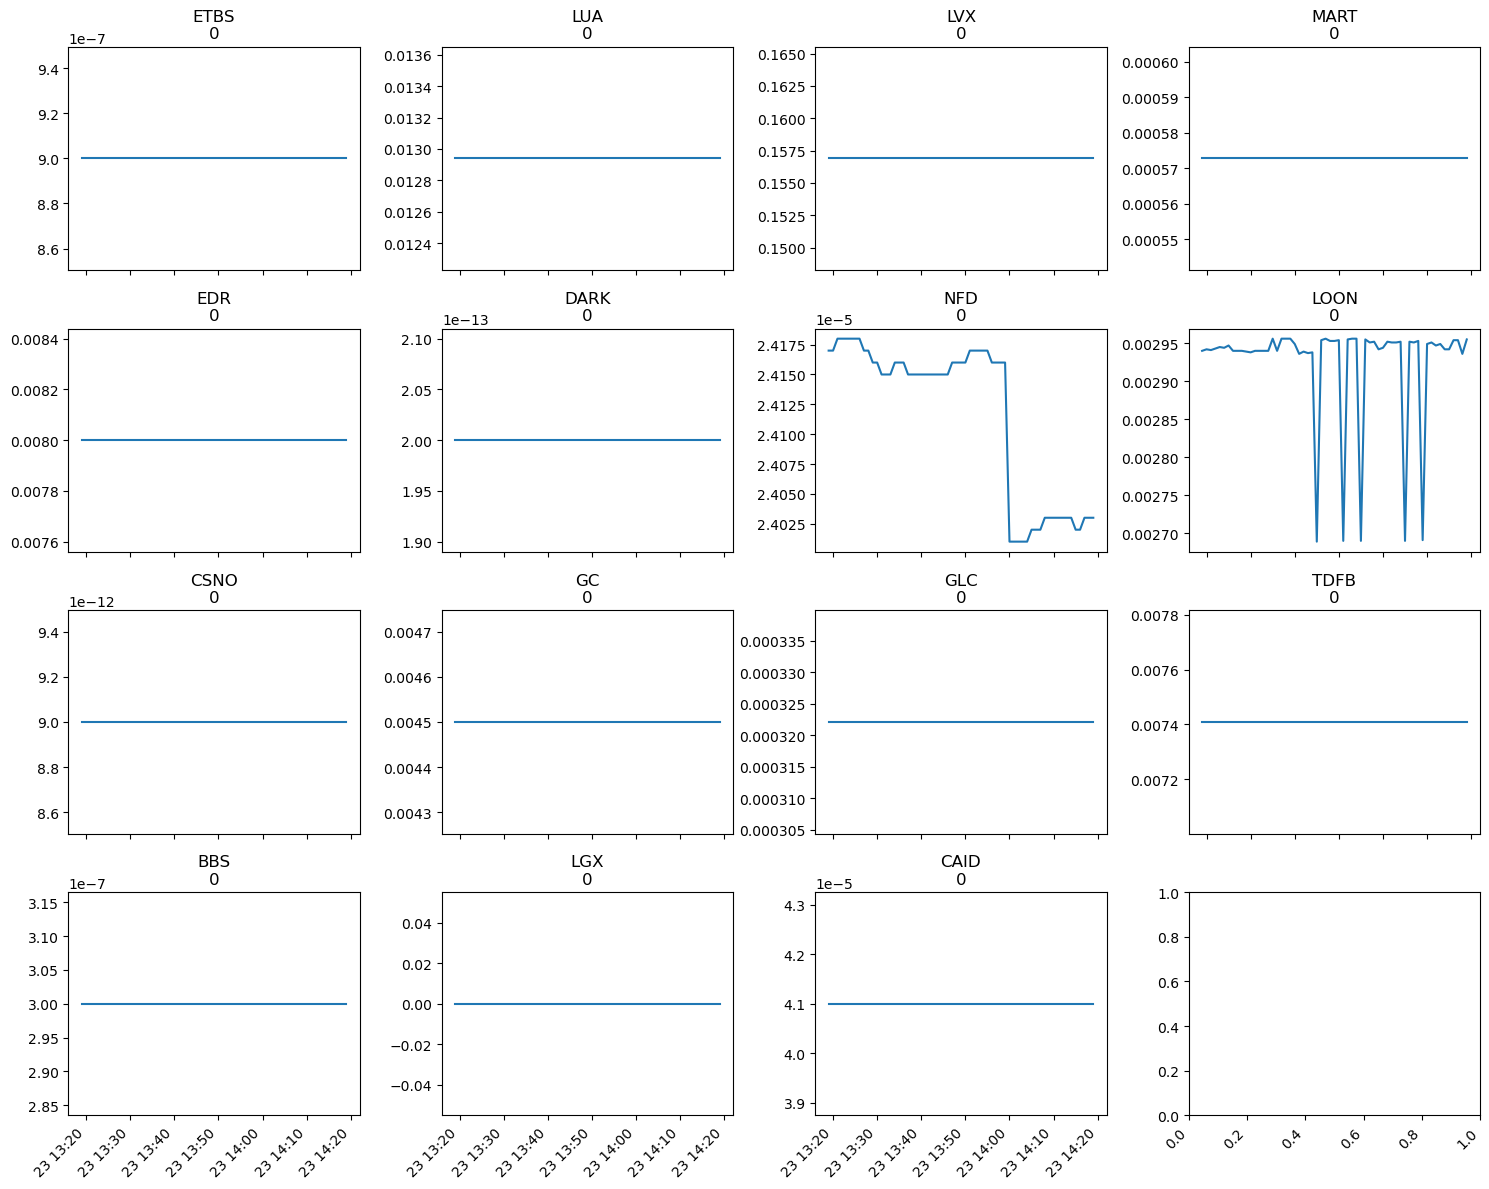

                          Cluster number: 1


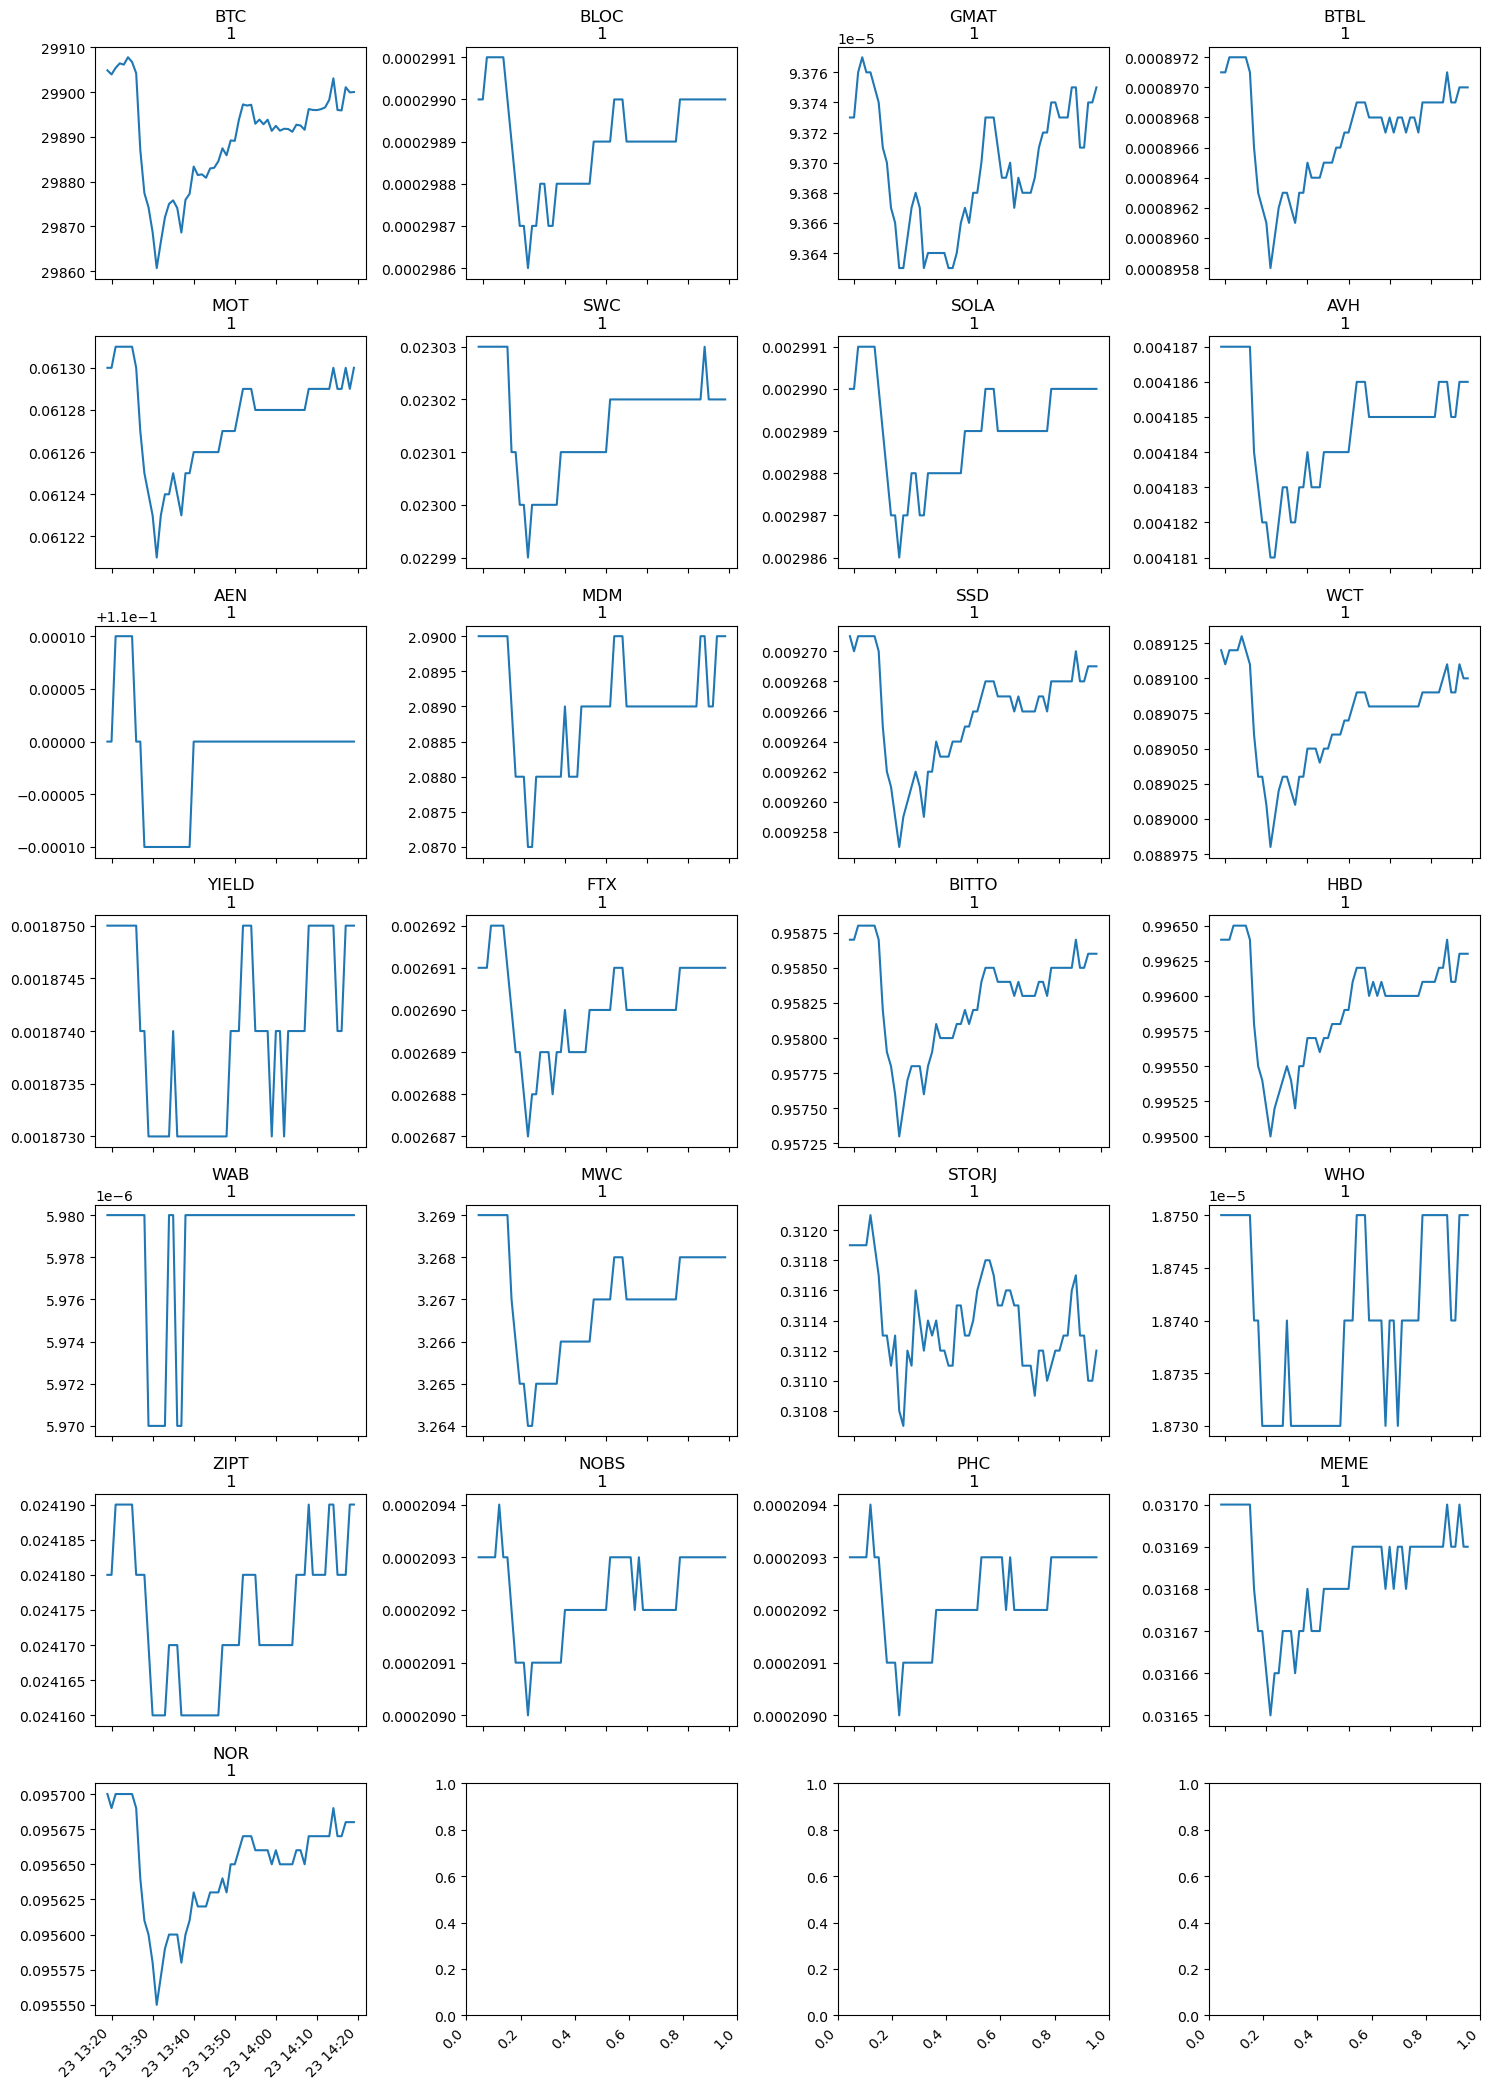

                          Cluster number: 2


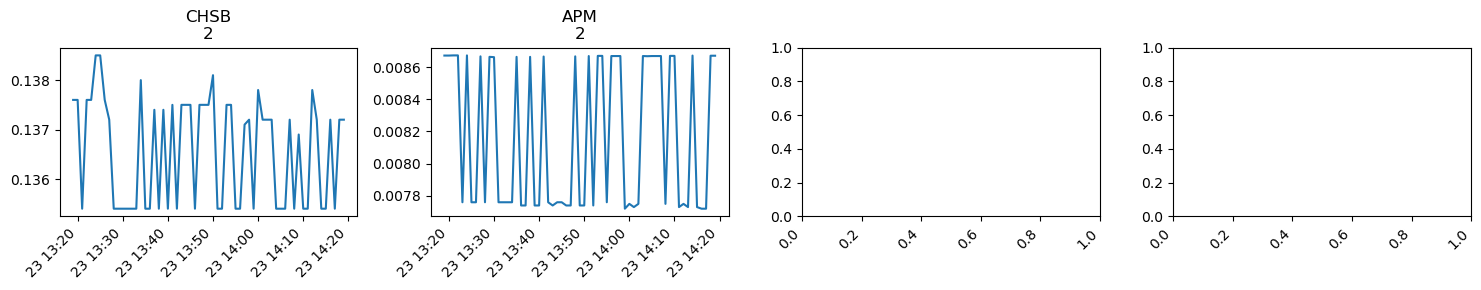

                          Cluster number: 3


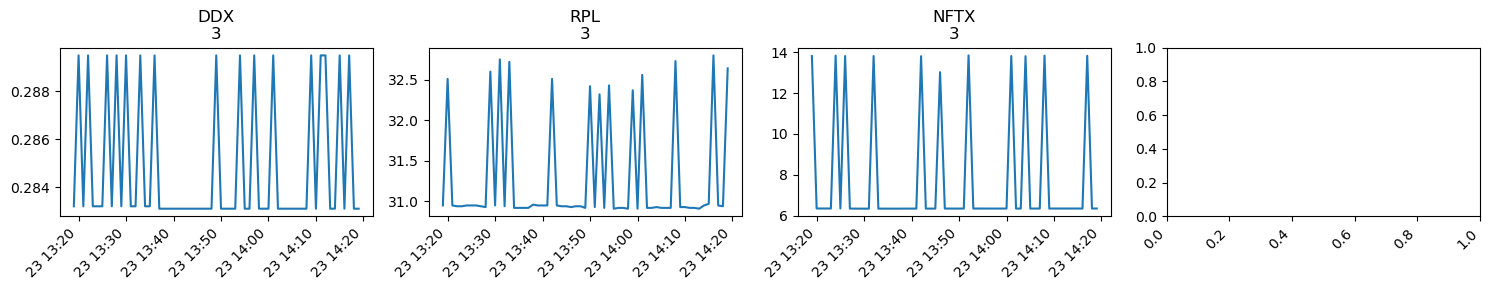

                          Cluster number: 4


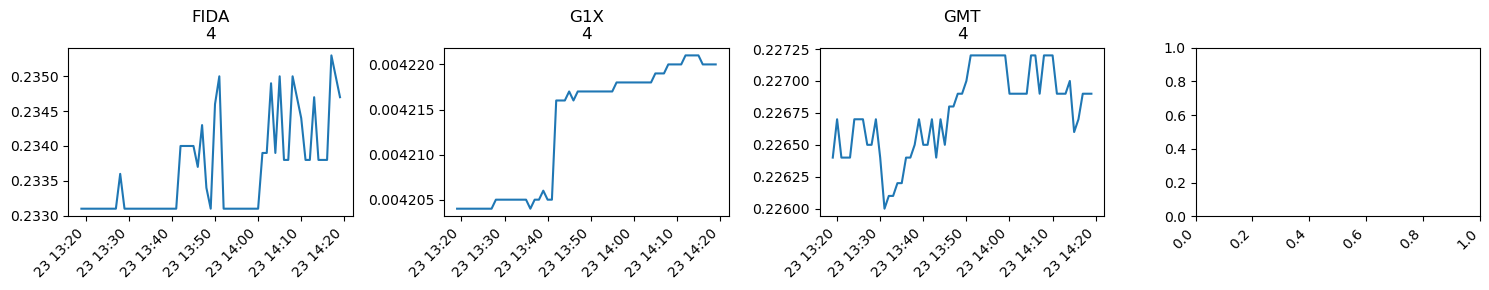

                          Cluster number: 5


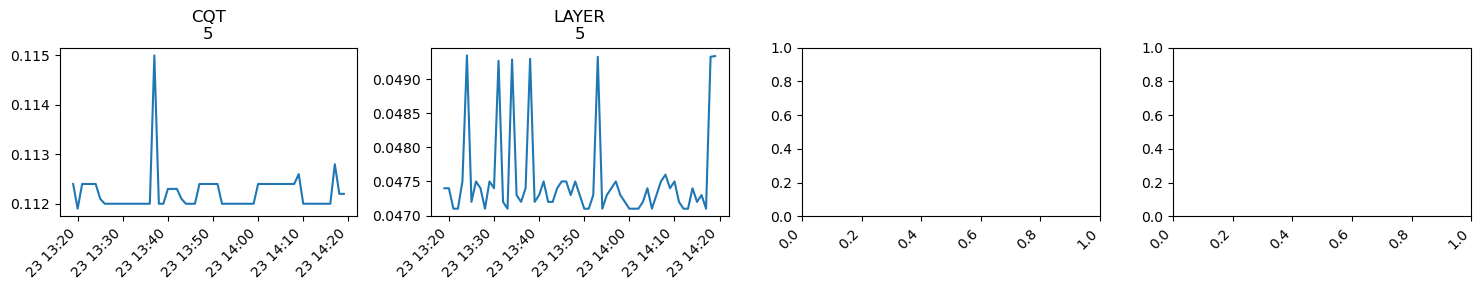

In [31]:
n_clusters = 6
ts_kmeans, df = train_and_plot_algo(n_clusters, tickers_scaled, full_ticker_df, "dtw")
results_of_clustering['min_dtw'] = show_tikers_in_claster(df)
plot_cluster_tickers_for_clusters(df, n_clusters)

# Analyze results
Как видно, все подходы группируют похожим образом 

биткоин оказывается в одной группе с одинаковыми монетами (BTC, BLOC, BTBL ...)

однако есть отличия в групировках с другими монетами

In [32]:
pd.concat(results_of_clustering, ignore_index=False, axis=1)

day  \
                                                                                                    ticker   
cluster                                                                                                      
0                                                                                                  APM G1X   
1        ETBS LUA LVX GMAT BTBL MOT CHSB AEN YIELD GMT MART EDR DARK BITTO HBD WAB MWC STORJ CSNO NFTX LGX   
2                                       BTC BLOC RPL SWC SOLA AVH MDM SSD WCT FTX WHO ZIPT NOBS GC PHC BBS   
3                                                                                            DDX FIDA TDFB   
4                                                                                             NFD LOON NOR   
5                                                                                  CQT LAYER GLC MEME CAID   

                                 \
        № of tickers in claster   
cluster                           
0                             2   
1                            21   
2                            16   
3                             3   
4                             3   
5                             5   

                                                             hour  \
                                                           ticker   
cluster                                                             
0                          DDX LAYER YIELD GMT WHO ZIPT TTV BOLTT   
1          ETBS BTBL MOT APM AEN MART BITTO WAB JCT LTZ MOAC BQTX   
2        BTC BLOC SOLA AVH MDM SSD WCT FTX HBD MWC STORJ INC TIMI   
3                      LUA LVX RPL CHSB CQT FIDA G1X EDR DARK WAY   
4                                              GMAT SWC NFD CORAL   
5                                                    NOTE SBR DKA   

                                 \
        № of tickers in claster   
cluster                           
0                             8   
1                            12   
2                            13   
3                            10   
4                             4   
5                             3   

                                                                                                                  min  \
                                                                                                               ticker   
cluster                                                                                                                 
0                                                                                                                 WAB   
1        BTC BLOC GMAT BTBL MOT SWC SOLA AVH AEN MDM SSD WCT YIELD FTX BITTO HBD MWC STORJ WHO ZIPT NOBS PHC MEME NOR   
2                                                                                                                 RPL   
3                           ETBS LUA LVX DDX CHSB LAYER APM MART EDR DARK NFD LOON CSNO GC GLC TDFB NFTX BBS LGX CAID   
4                                                                                                        FIDA G1X GMT   
5                                                                                                                 CQT   

                                 \
        № of tickers in claster   
cluster                           
0                             1   
1                            24   
2                             1   
3                            20   
4                             3   
5                             1   

                                                              day_dtw  \
                                                               ticker   
cluster                                                                 
0                                      DDX APM G1X LOON GLC MEME STOX   
1                   BTC BLOC FIDA MDM SSD WCT GMT FTX PHC BBS SLX INC   
2                             LUA LVX MART EDR DARK TDFB LGX CADN WAY   
3             